In [ ]:
import math
!pip install yfinance 
import yfinance as yf
import numpy as np
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
from datetime import datetime
#import matplotlib.colors as colors
import plotly.graph_objects as go
import matplotlib.style
plt.style.use('fivethirtyeight')
# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy import stats
!pip install 
import pyfolio as pf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import datetime
from datetime import datetime

In [ ]:
import seaborn as sns
import warnings
plt.style.use('seaborn')
sns.set_palette('cubehelix')

plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
equities = [
'XOM',
'MPC',
'IMCG',
'EFA',
'ASML',
'TECL',
'QCLN',
'SPGP',
'DIG',
'GRID',
'PXE'
]
end = datetime.now()
#Start date set to 10 year back
start = datetime(end.year-5,end.month,end.day) 
pricedata = yf.download(equities,start,end)['Adj Close']
n_equities = len(equities)


[*********************100%***********************]  11 of 11 completed


In [ ]:
n_equities


11

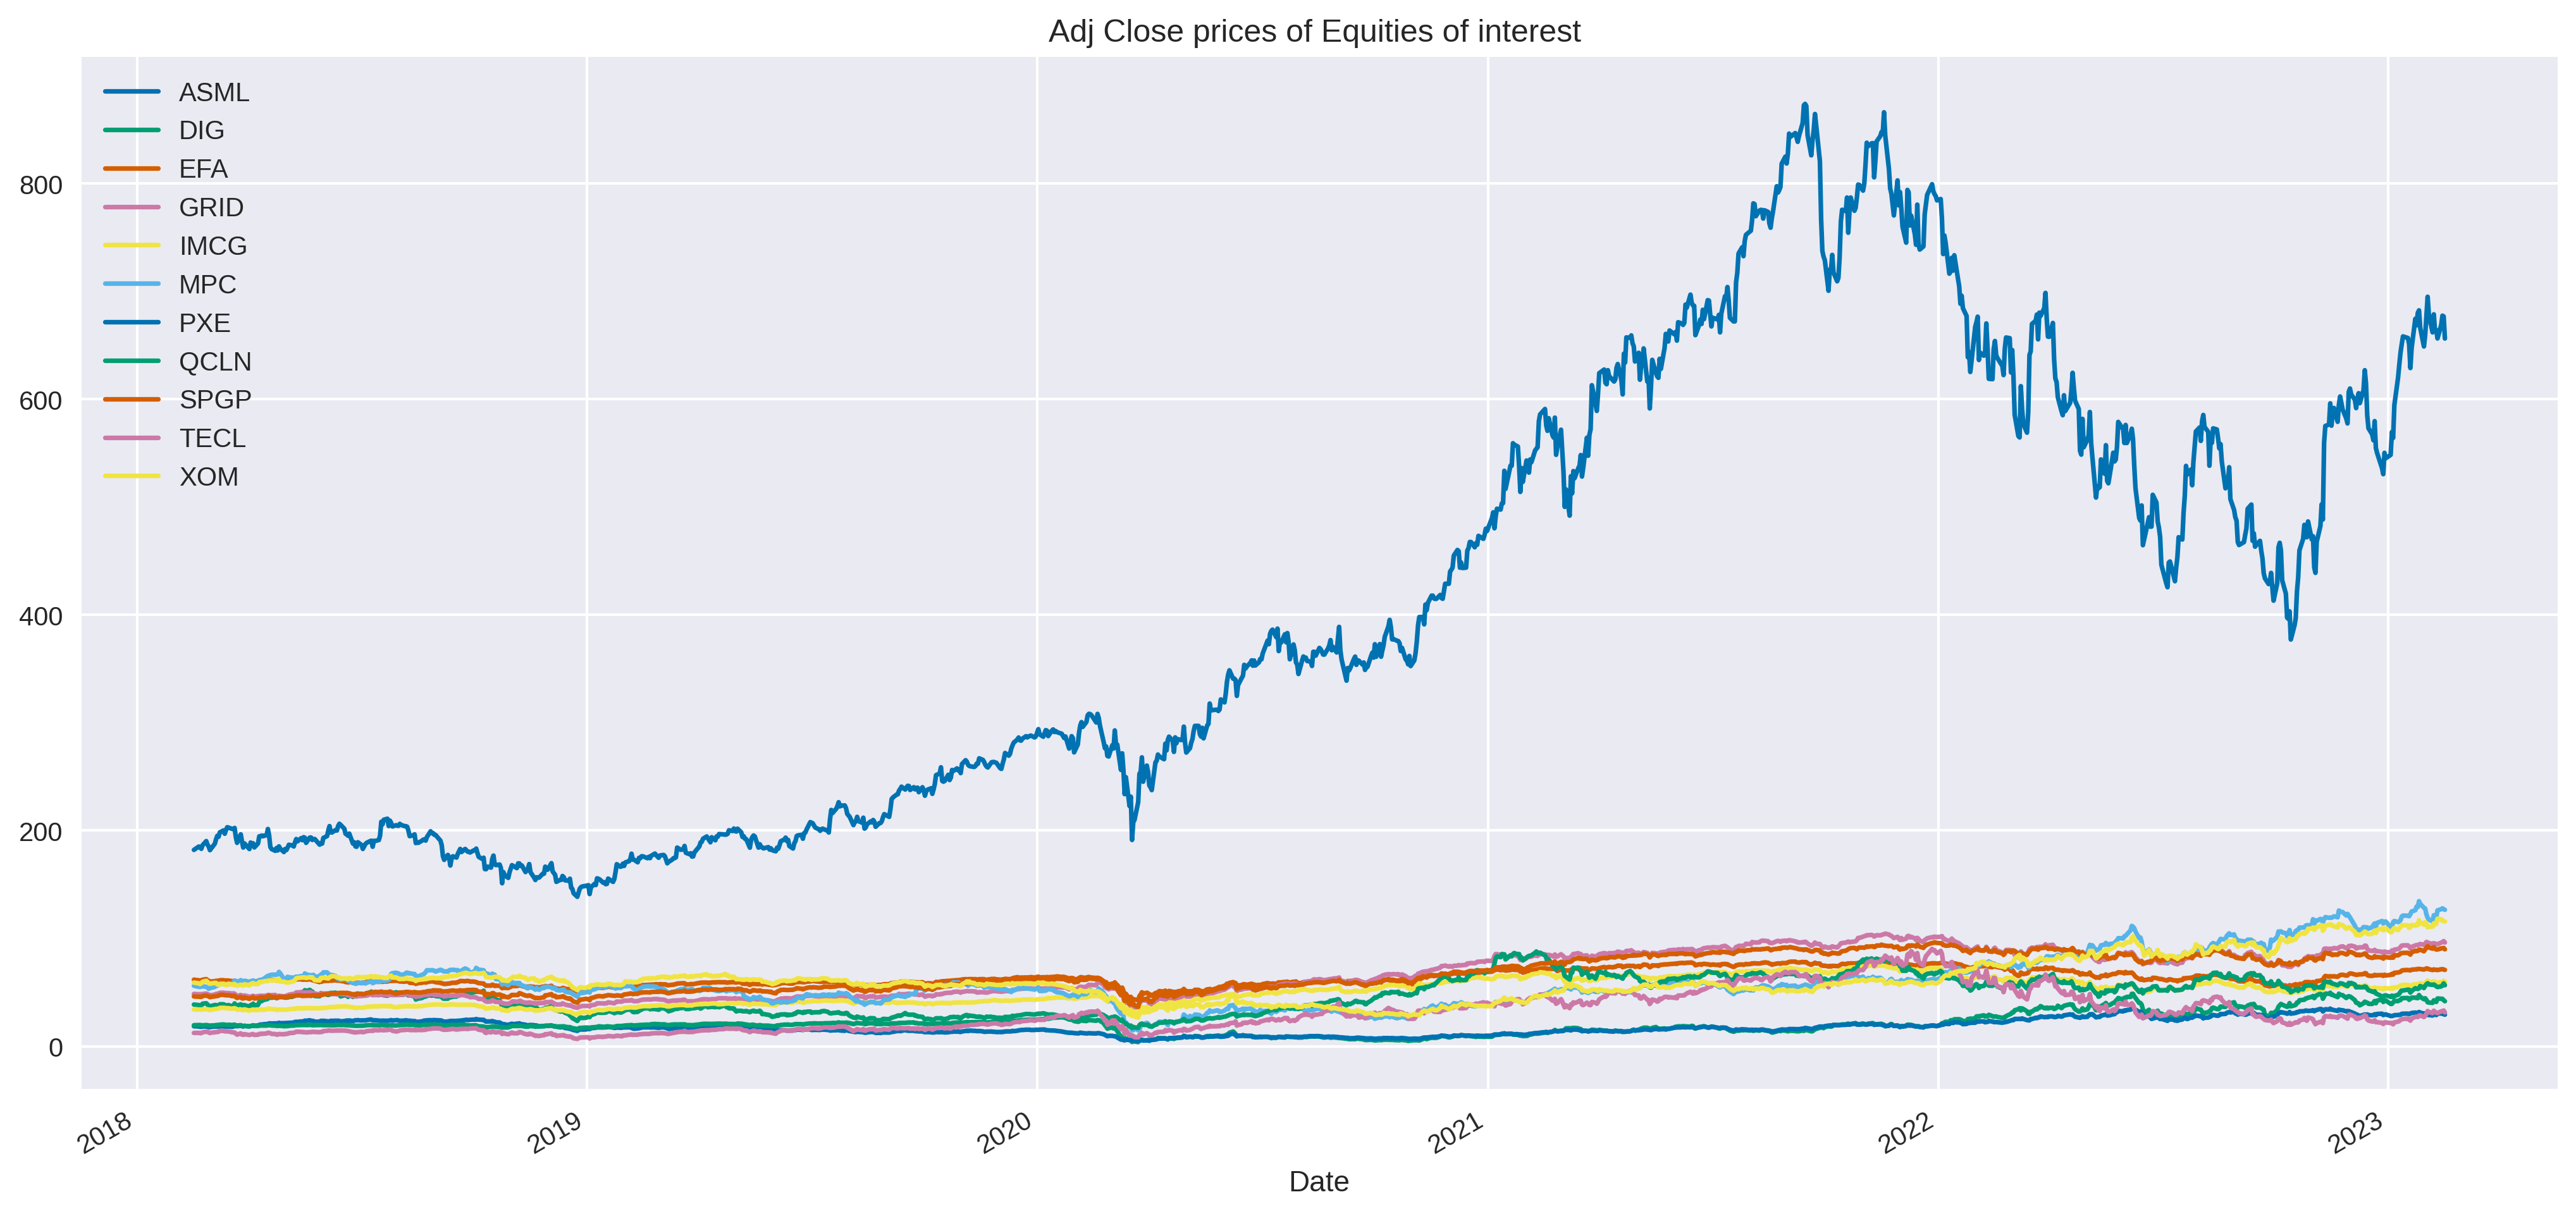

In [ ]:
pricedata.plot(title='Adj Close prices of Equities of interest ', figsize = (15,8))
plt.show()

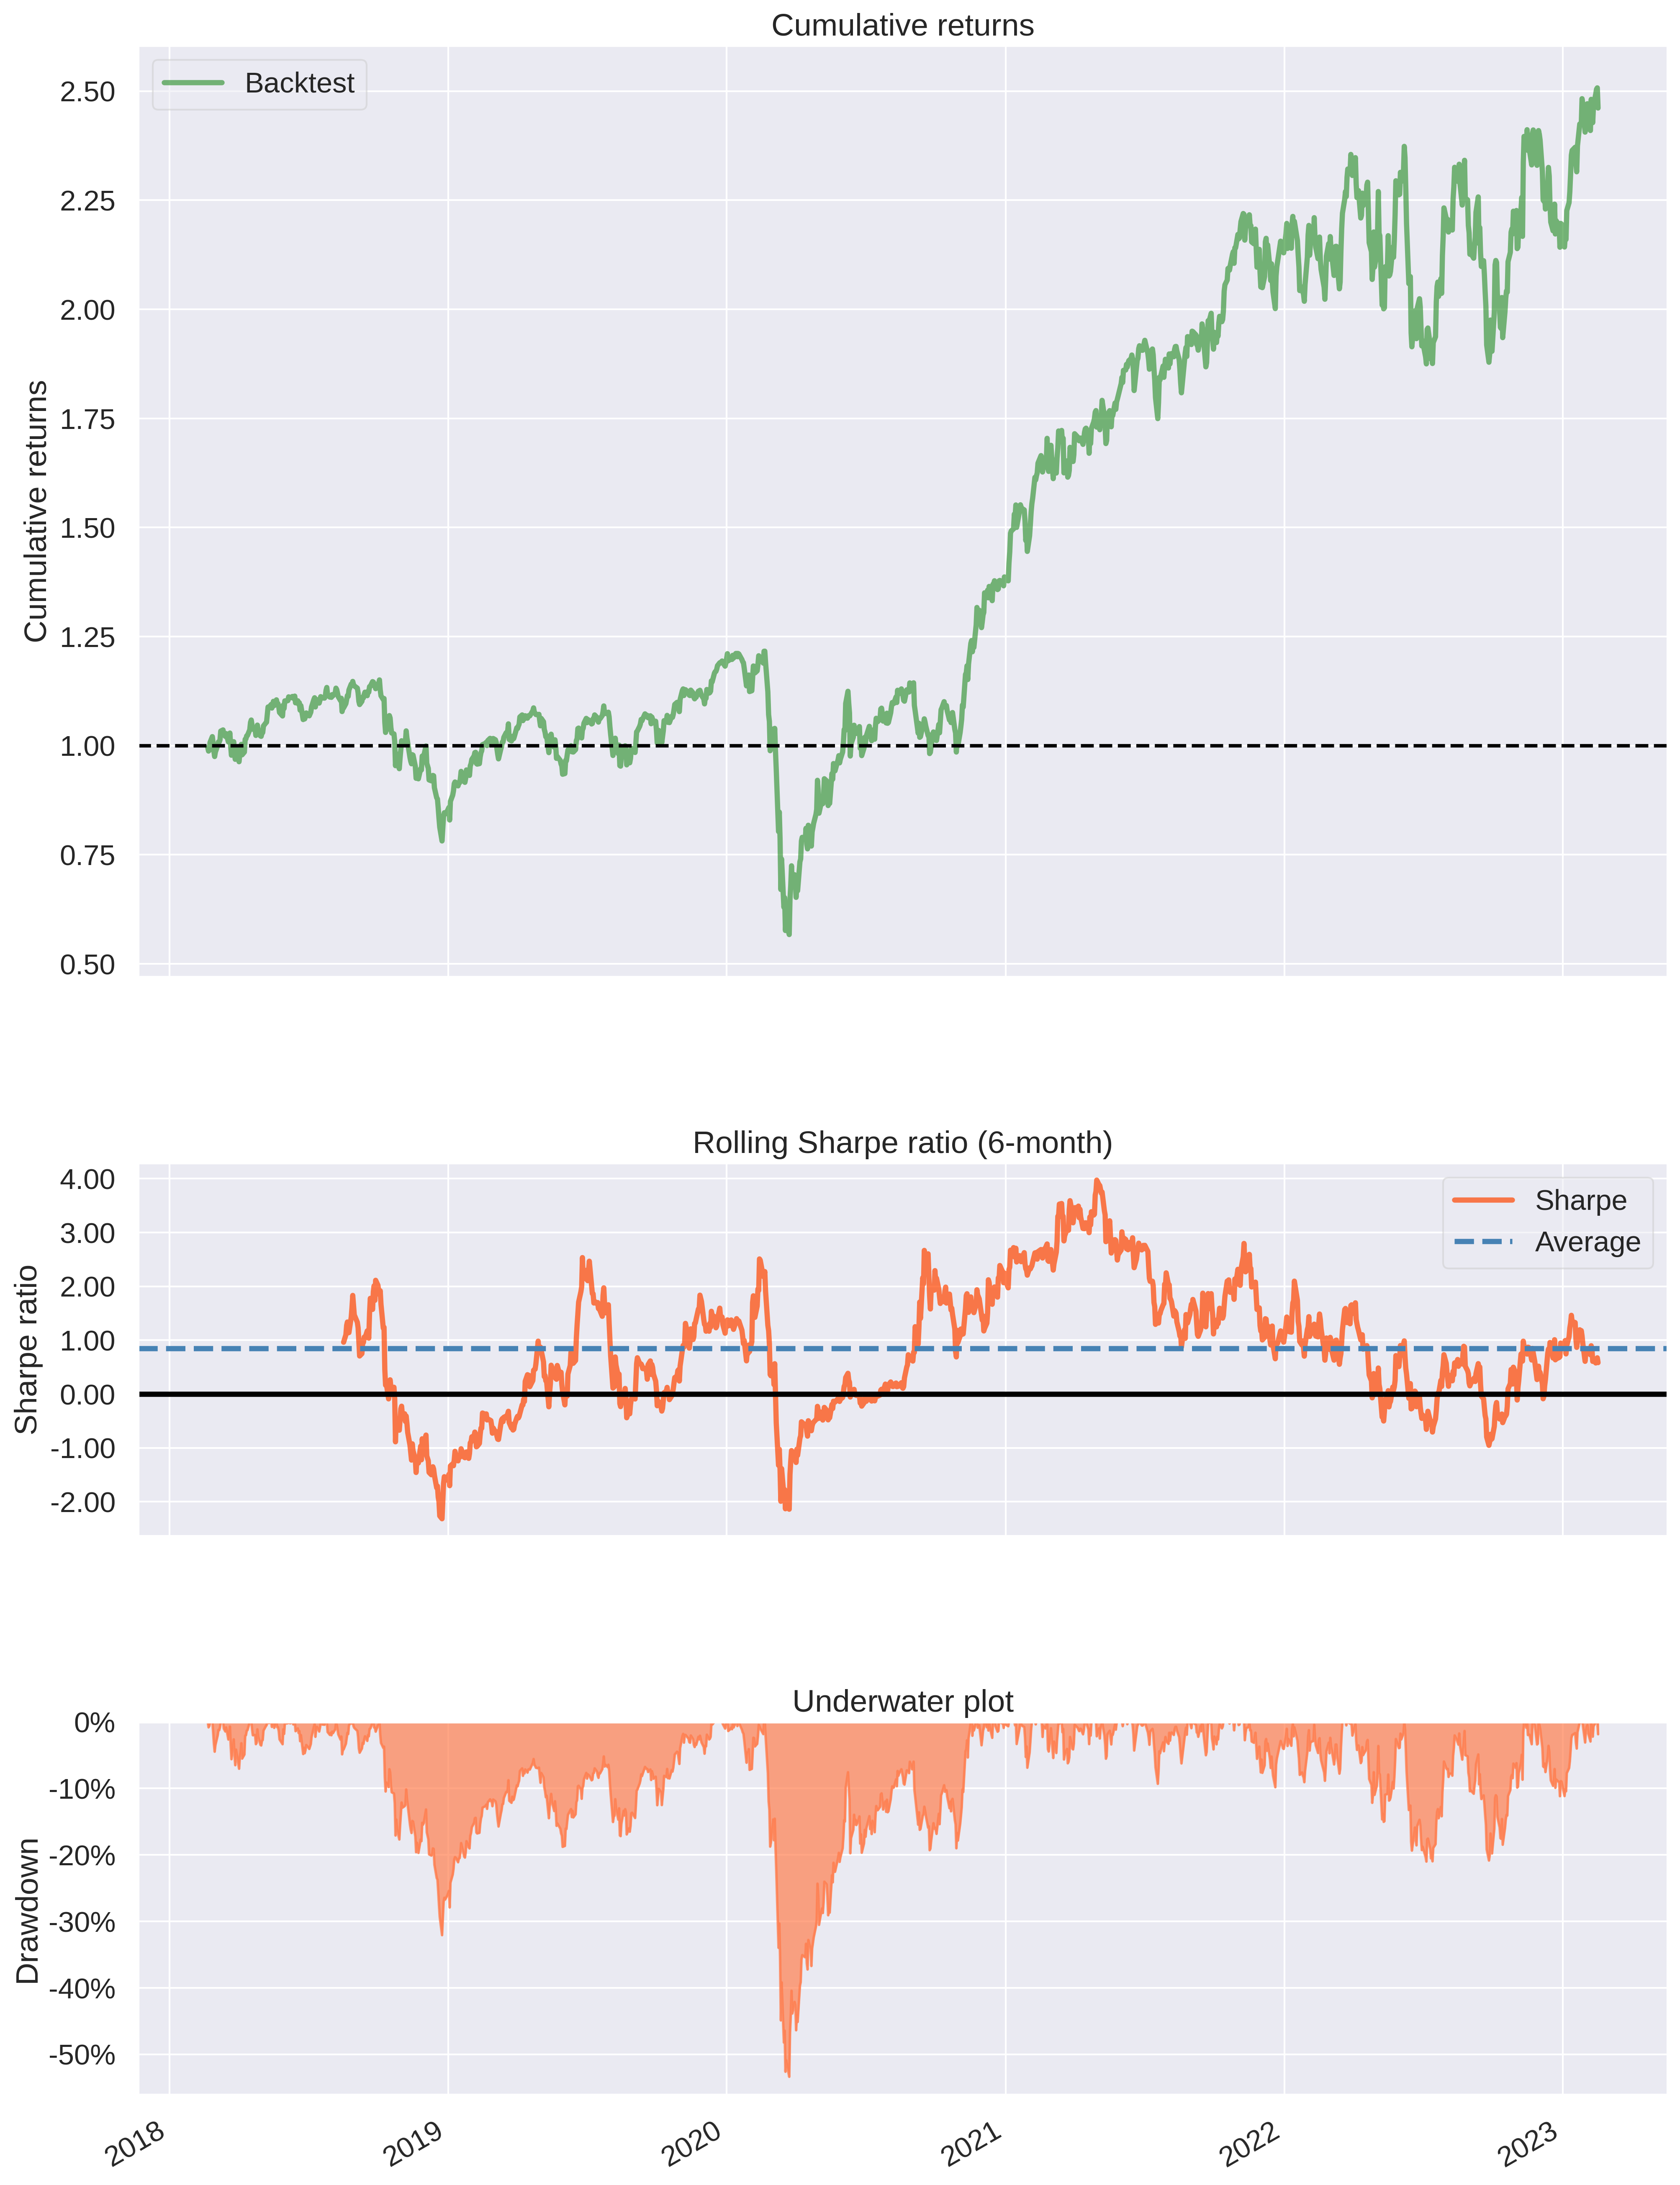

In [ ]:
# returns
returns = pricedata.pct_change().dropna()

# weights
portfolio_weights = n_equities * [1 / n_equities]

# portfolio return
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), 
                              index=returns.index)

# simple tear sheet
pf.create_simple_tear_sheet(portfolio_returns)

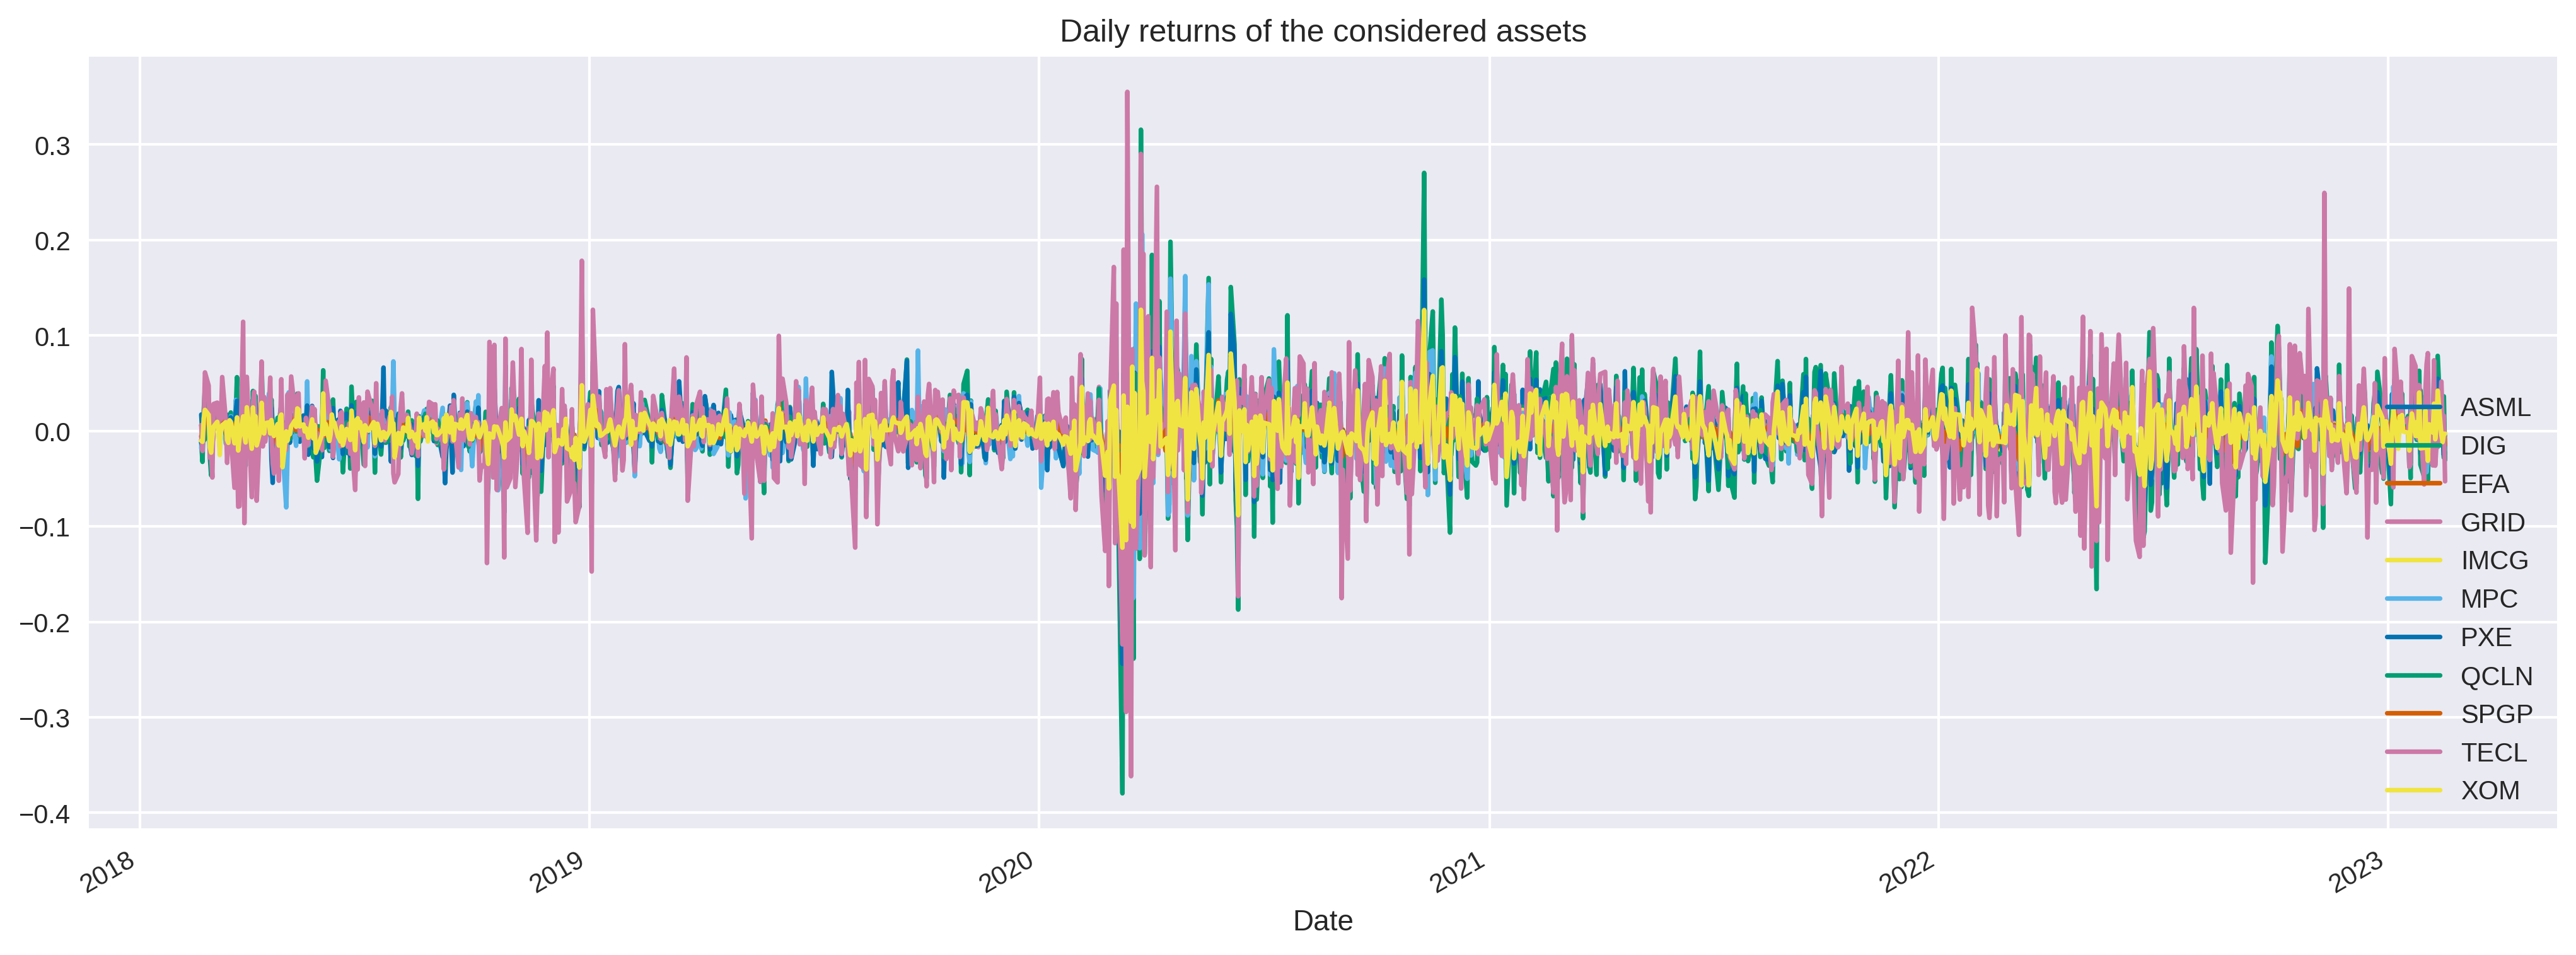

In [ ]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252

returns = pricedata.pct_change().dropna()
avg_returns = returns.mean() * N_DAYS
cov_mat = returns.cov() * N_DAYS

returns.plot(title='Daily returns of the considered assets', figsize = (15,6));
     

In [ ]:
# simulation random portfolio returns
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_equities))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

# portfolio metric
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

# joit dataframe
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio}).dropna()


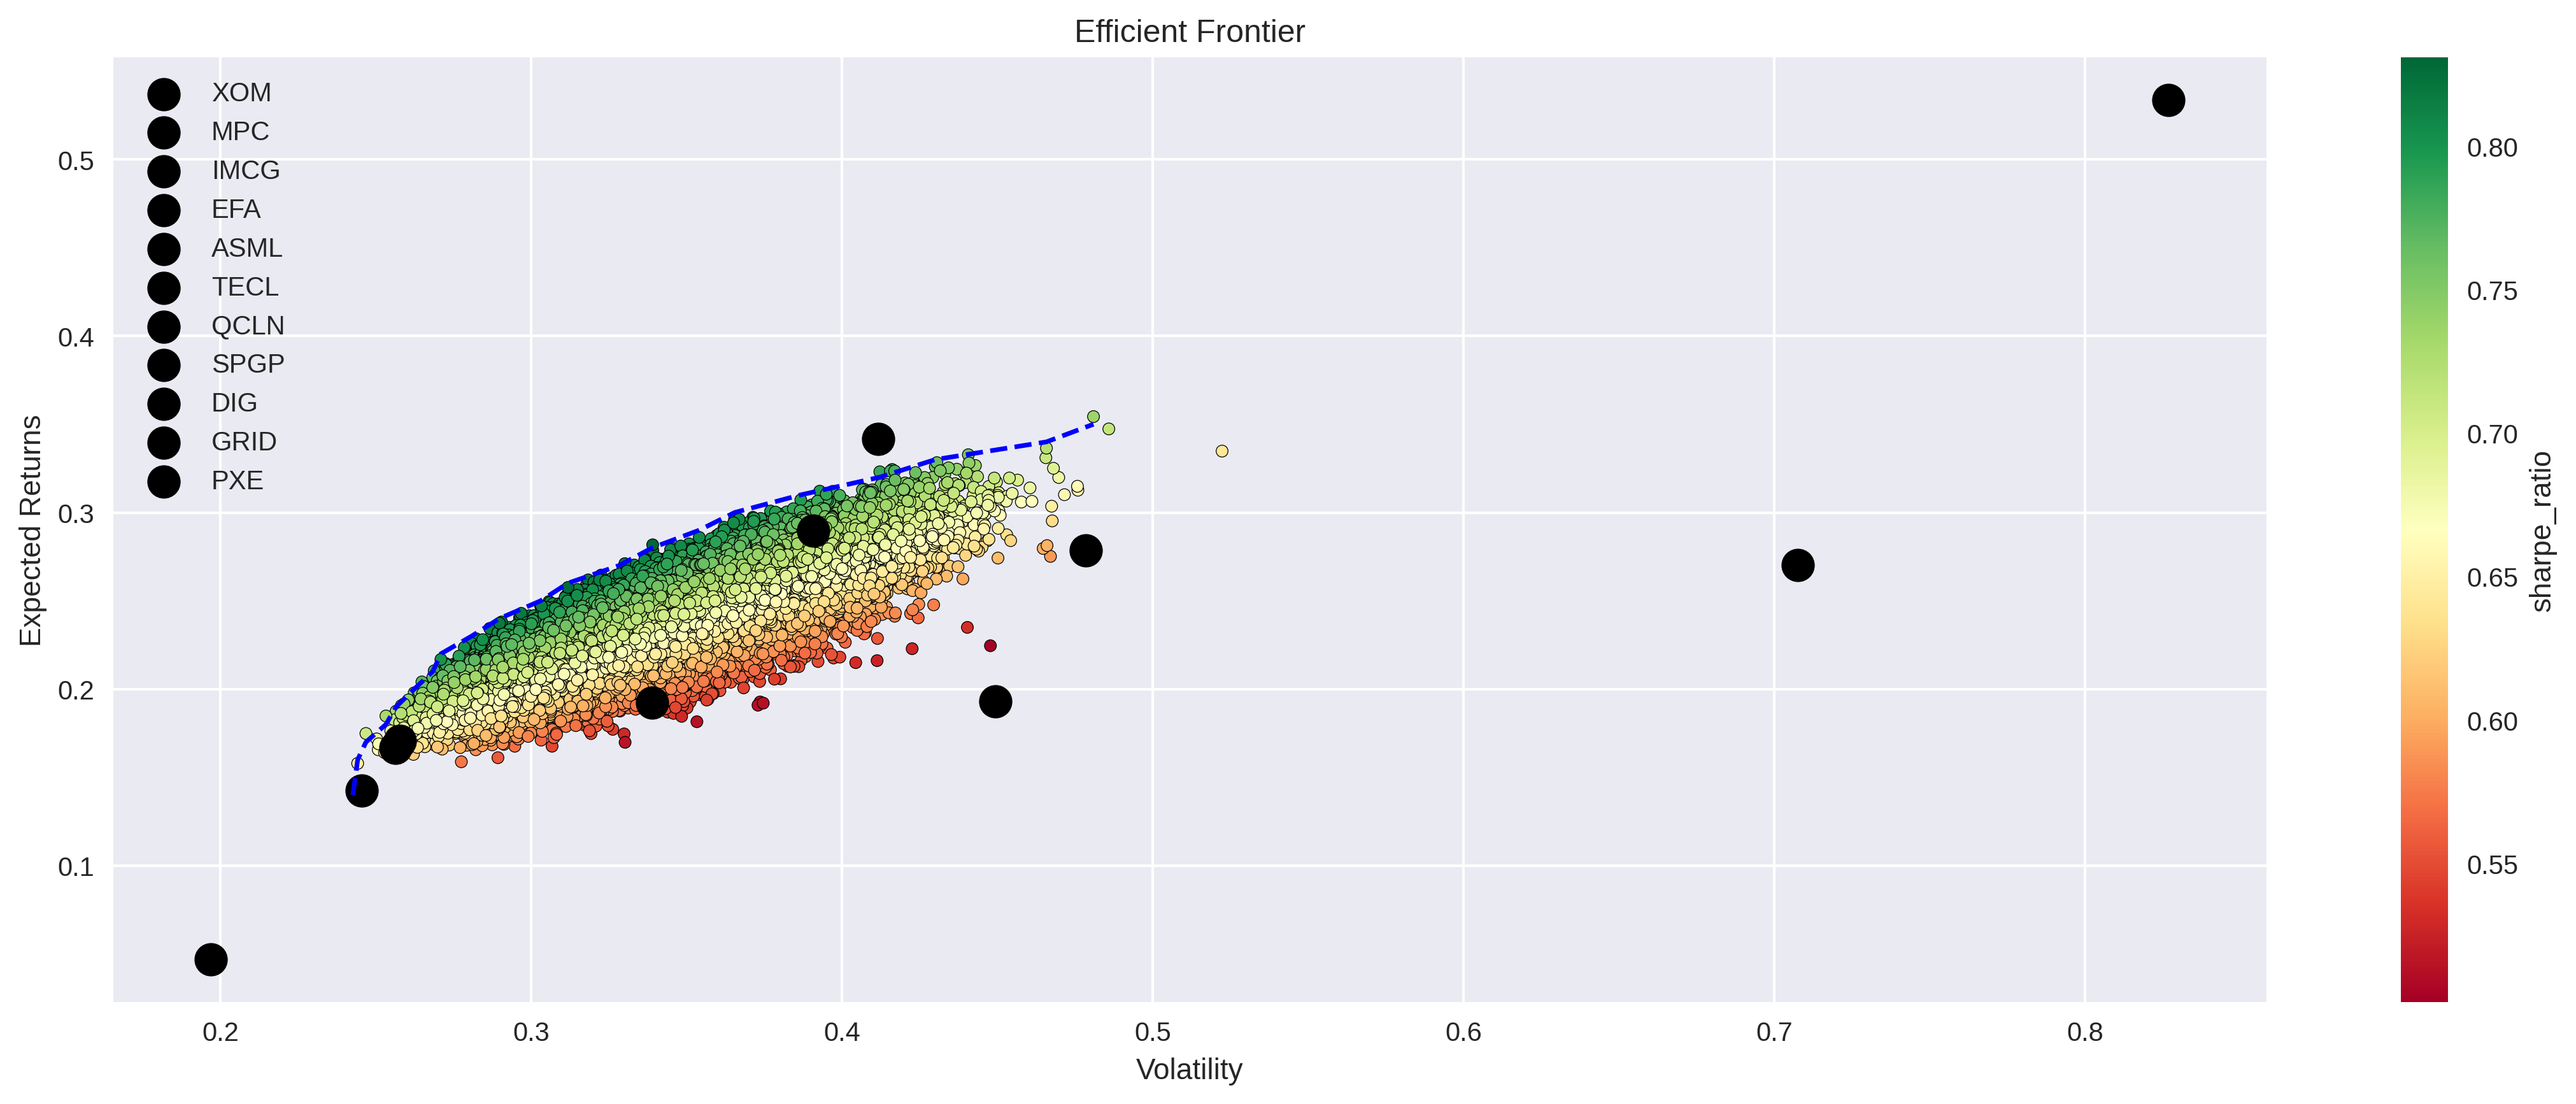

In [ ]:
# Locate the points creating the Efficient Frontier:

N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

# Plot the Efficient Frontier:

MARKS = ['o','o','o','o','o','o','o','o','o','o','o']

fig, ax = plt.subplots(figsize=(15,6))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_equities):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=equities[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]


print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(equities, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)


Maximum Sharpe Ratio portfolio ----
Performance
returns: 28.17% volatility: 33.90% sharpe_ratio: 83.10% 
Weights
XOM: 20.91% MPC: 1.18% IMCG: 0.85% EFA: 1.92% ASML: 5.34% TECL: 13.93% QCLN: 0.46% SPGP: 28.90% DIG: 11.76% GRID: 7.14% PXE: 7.61% 

In [ ]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(equities, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 13.99% volatility: 24.26% sharpe_ratio: 57.70% 
Weights
XOM: 1.45% MPC: 4.81% IMCG: 29.62% EFA: 11.76% ASML: 29.42% TECL: 0.64% QCLN: 5.15% SPGP: 0.48% DIG: 4.23% GRID: 0.58% PXE: 11.85% 

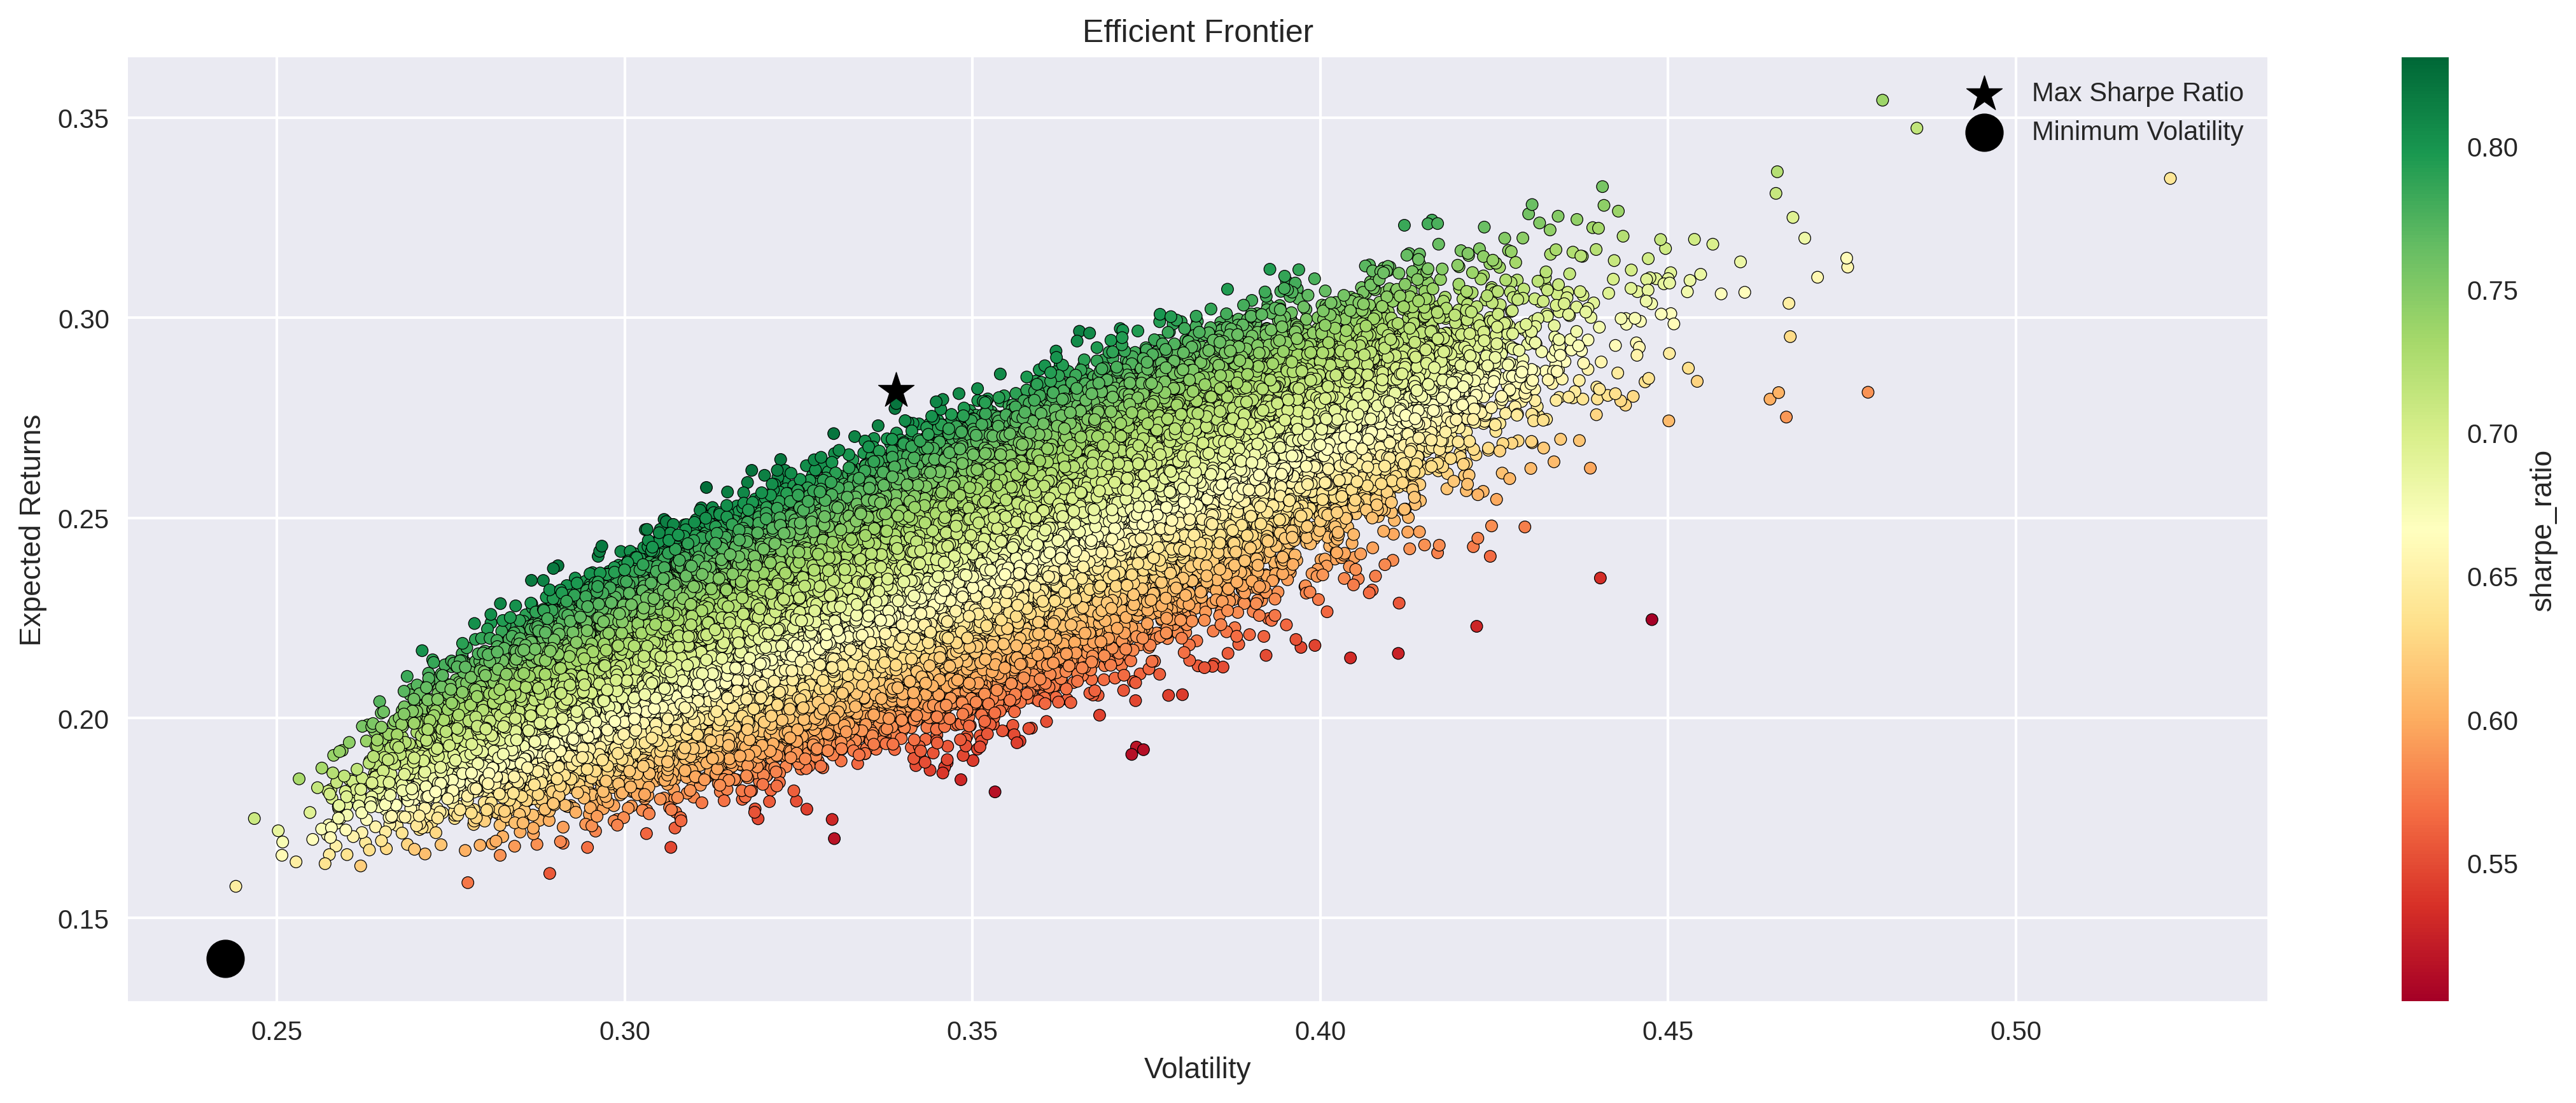

In [ ]:
fig, ax = plt.subplots(figsize = (15,6))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='o', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.show()
     


In [ ]:
!pip install cvxpy
import cvxpy as cp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/cvxpy/expressions/expression.py:593: UserWarning:


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.




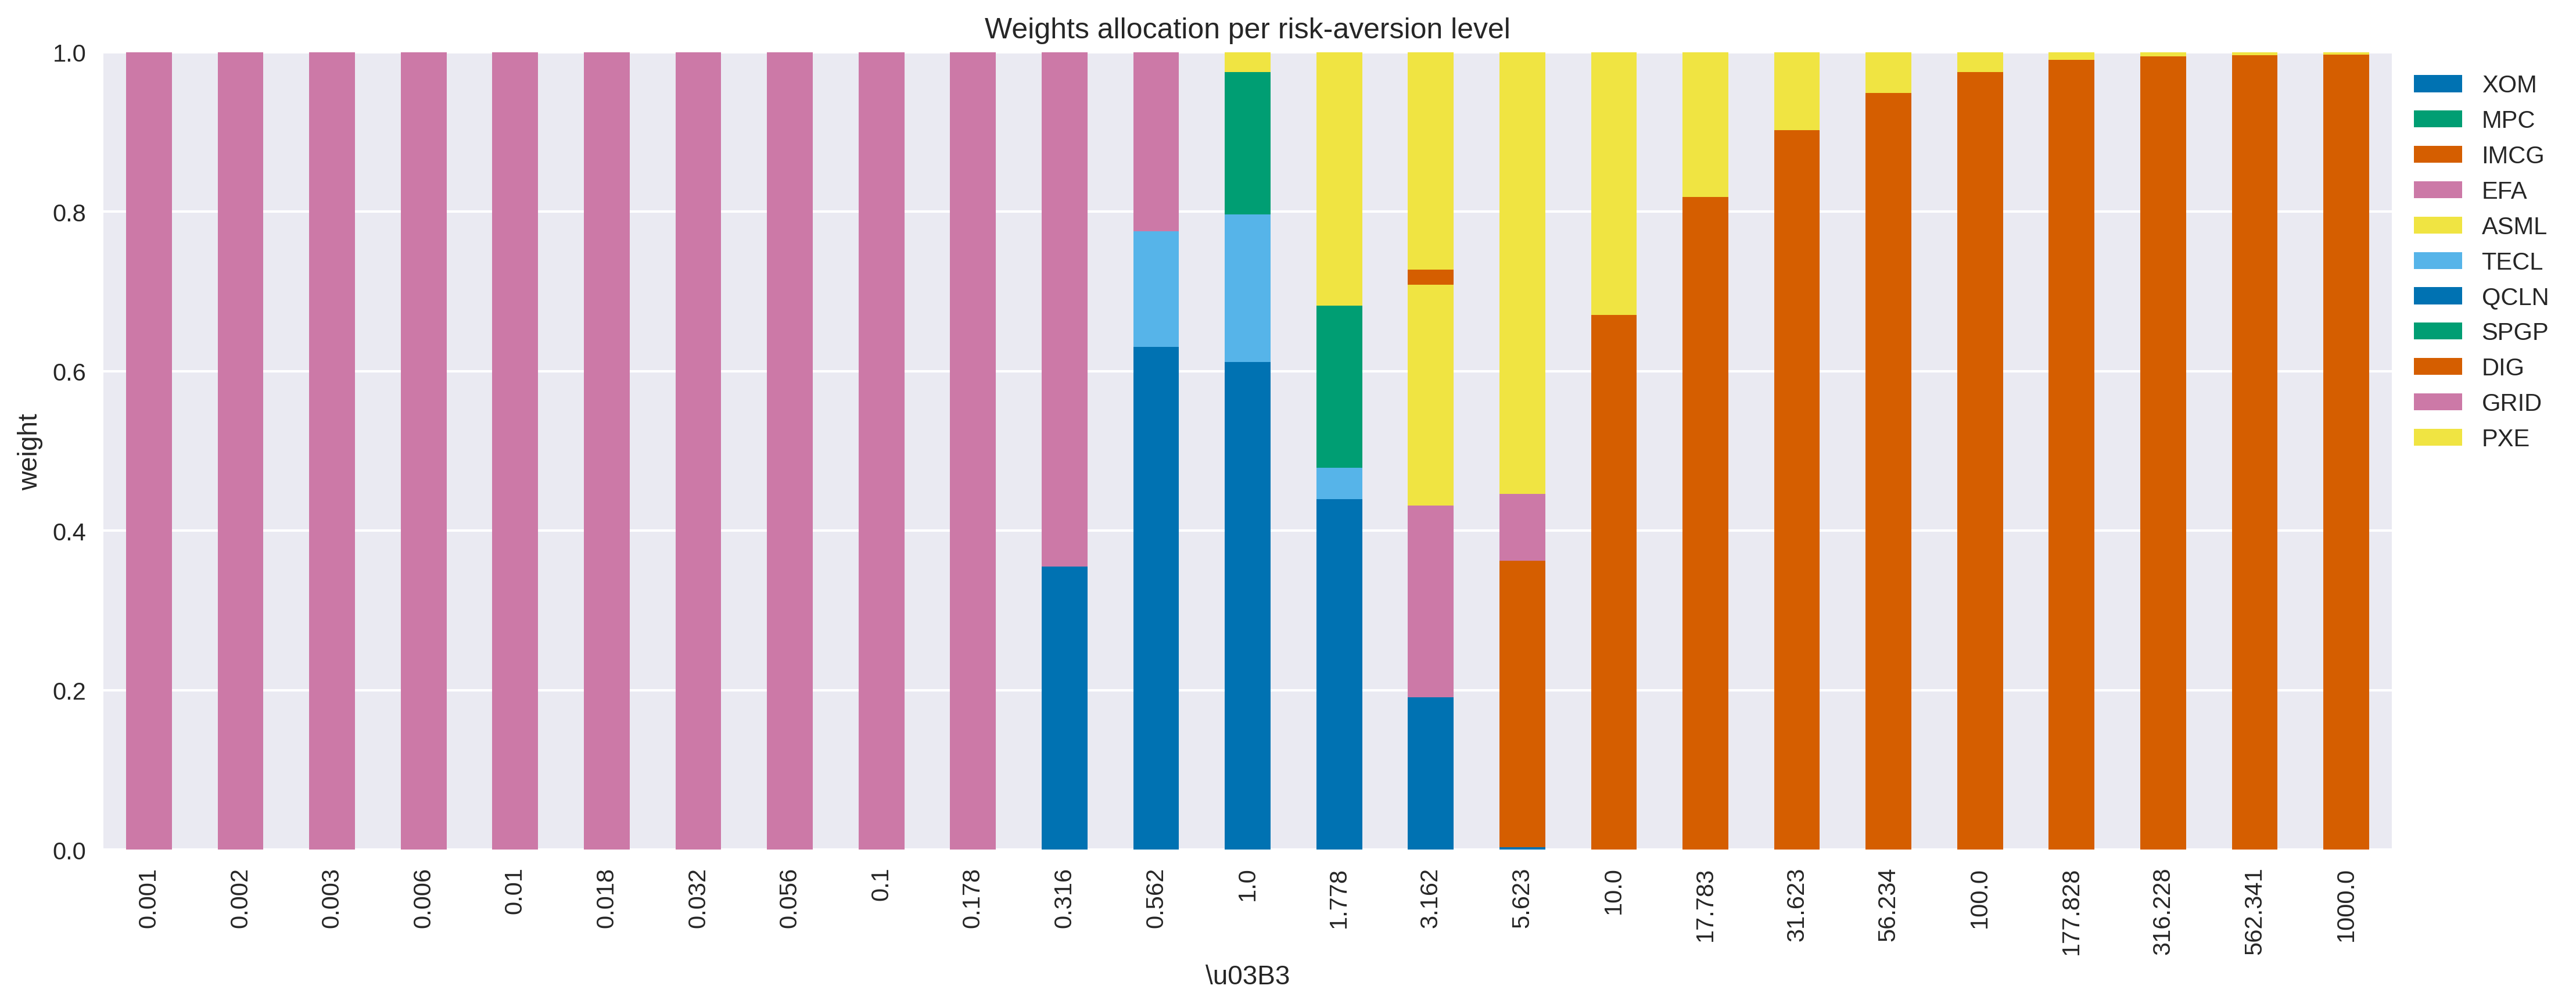

In [ ]:

# Convert the annualized average returns and the covariance matrix to numpy arrays:
avg_returns = avg_returns
cov_mat = cov_mat
# Set up the optimization problem:
weights = cp.Variable(n_equities)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns * weights 
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function, 
                     [cp.sum(weights) == 1, weights >= 0])

# Calculate the Efficient Frontier:

N_POINTS = 25
portf_rtn_cvx_ef = np.zeros(N_POINTS)
portf_vol_cvx_ef = np.zeros(N_POINTS)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for i in range(N_POINTS):
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

# Plot the allocation for different values of the risk-aversion parameter:
weights_df = pd.DataFrame(weights_ef, 
                          columns=equities, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True, figsize = (15,6)) 
ax.set(title='Weights allocation per risk-aversion level',xlabel=r'\u03B3', ylabel='weight')

ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()
     

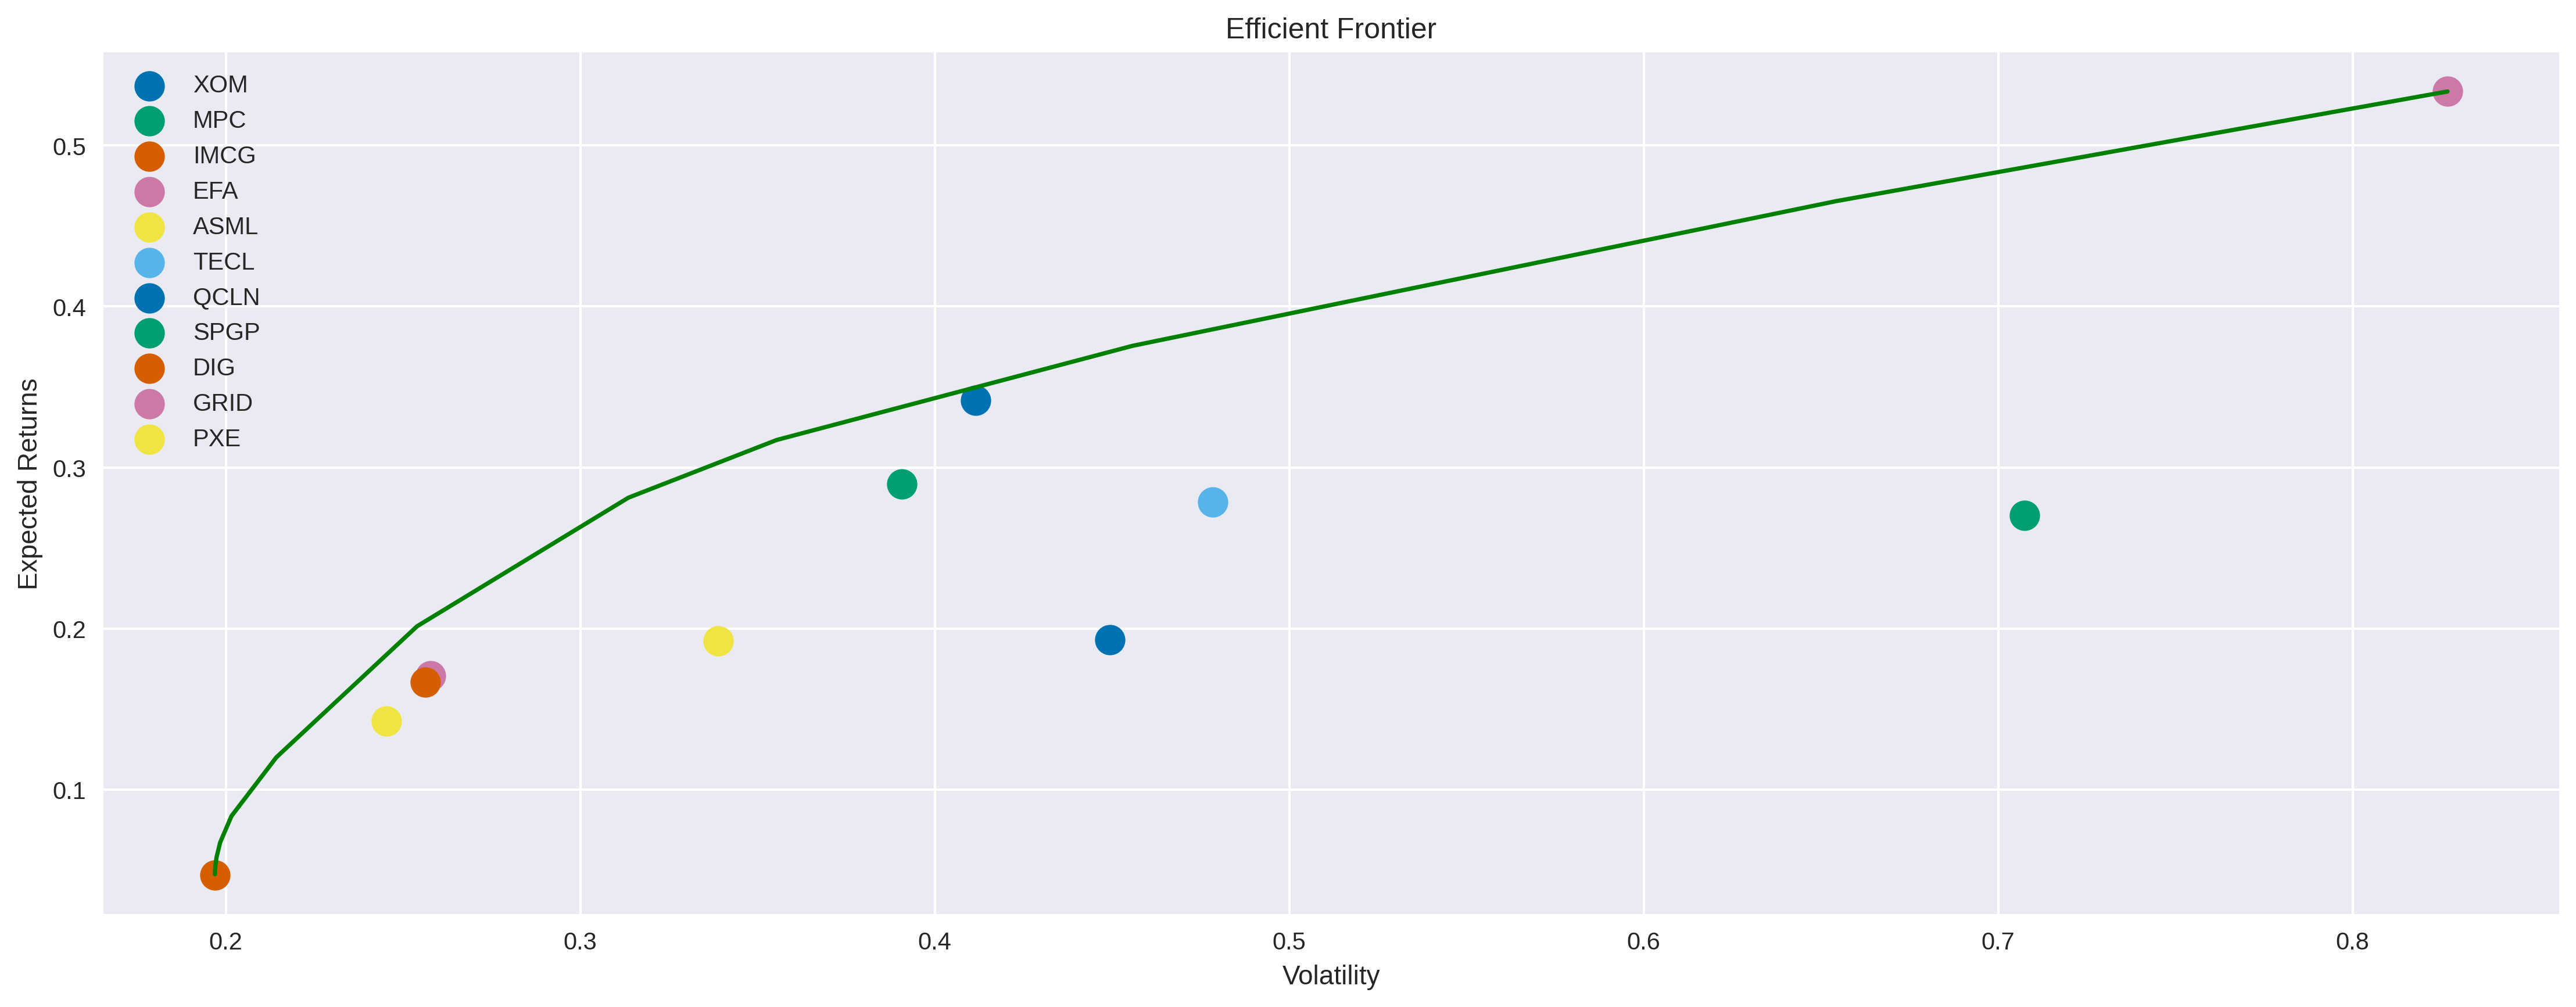

In [ ]:
# Plot the Efficient Frontier, together with the individual assets:
#MARKS = ['o','o','o','o','o','o','o','o','o']

fig, ax = plt.subplots(figsize = (15,6))
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_equities):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                #  marker=MARKS[asset_index], 
                 label=equities[asset_index],
                 s=150)
ax.set(title='Efficient Frontier',
       xlabel='Volatility', 
       ylabel='Expected Returns', )
ax.legend()

plt.tight_layout()
plt.show()

                                     CVXPY                                     
                                     v1.2.3                                    
(CVXPY) Feb 17 12:16:20 AM: Your problem has 11 variables, 2 constraints, and 2 parameters.
(CVXPY) Feb 17 12:16:20 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 17 12:16:20 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 17 12:16:20 AM: Compiling problem (target solver=SCS).
(CVXPY) Feb 17 12:16:20 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Feb 17 12:16:20 AM: Applying reduction FlipObjective
(CVXPY) Feb 17 12:16:20 AM: Applying reduction Dcp

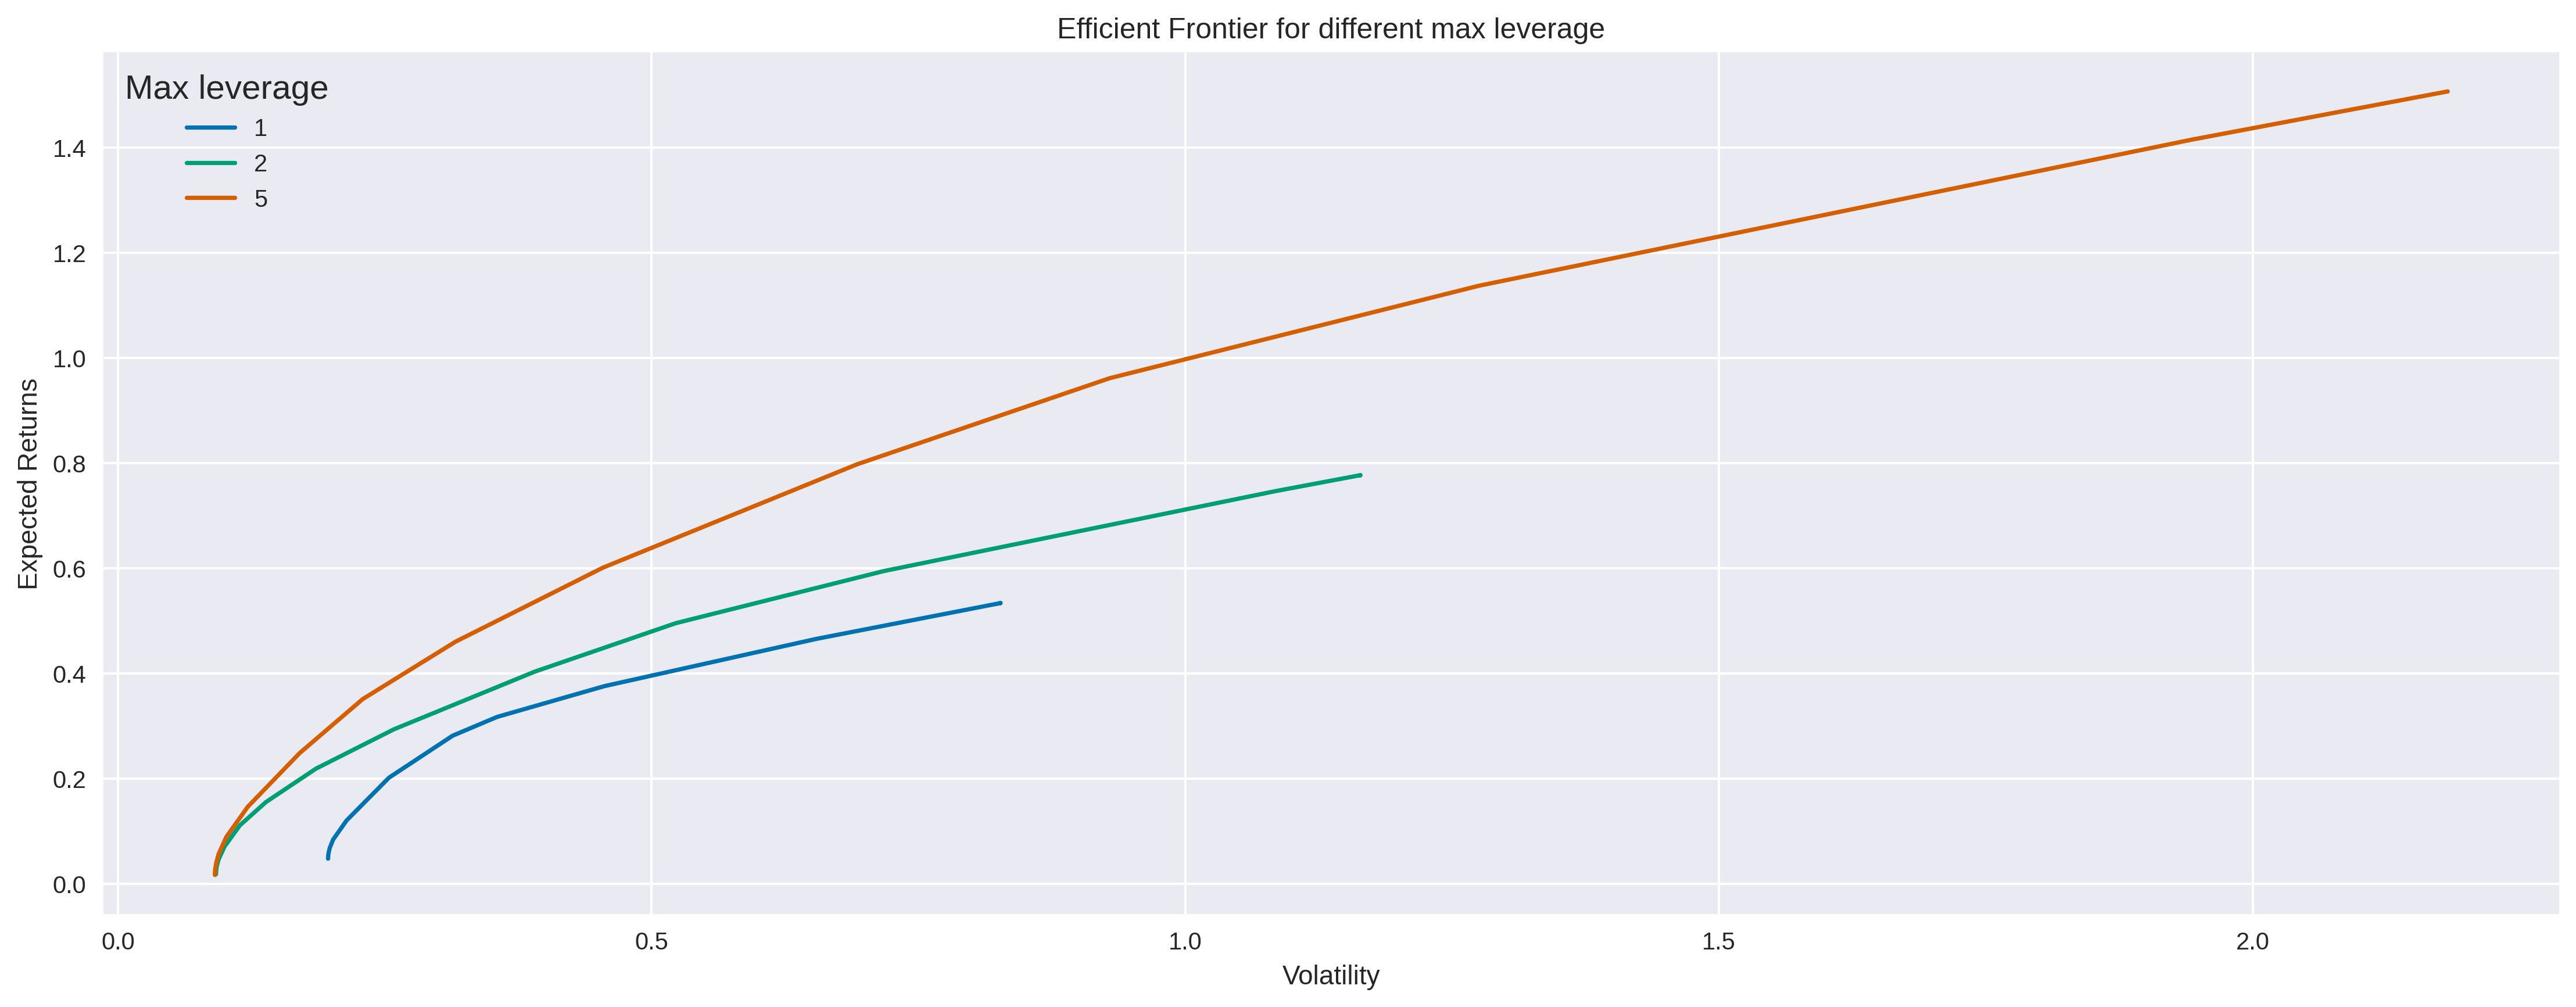

In [ ]:
max_leverage = cp.Parameter()
problem_with_leverage = cp.Problem(objective_function, 
                                   [cp.sum(weights) == 1, 
                                    cp.norm(weights, 1) <= max_leverage])


LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25

portf_vol_l_ef = np.zeros((N_POINTS, len_leverage))
portf_rtn_l_ef = np.zeros(( N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_equities))

for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
    for gamma_ind in range(N_POINTS):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve(solver=cp.SCS, verbose=True, use_indirect=True)
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value

fig, ax = plt.subplots(figsize = (15,6))

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l_ef[:, leverage_index], 
             portf_rtn_l_ef[:, leverage_index], 
             label=f'{leverage}')

ax.set(title='Efficient Frontier for different max leverage',
       xlabel='Volatility', 
       ylabel='Expected Returns')
ax.legend(title='Max leverage')

plt.tight_layout()
plt.show()

<ipython-input-111-bcdfe16e67e0>:19: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



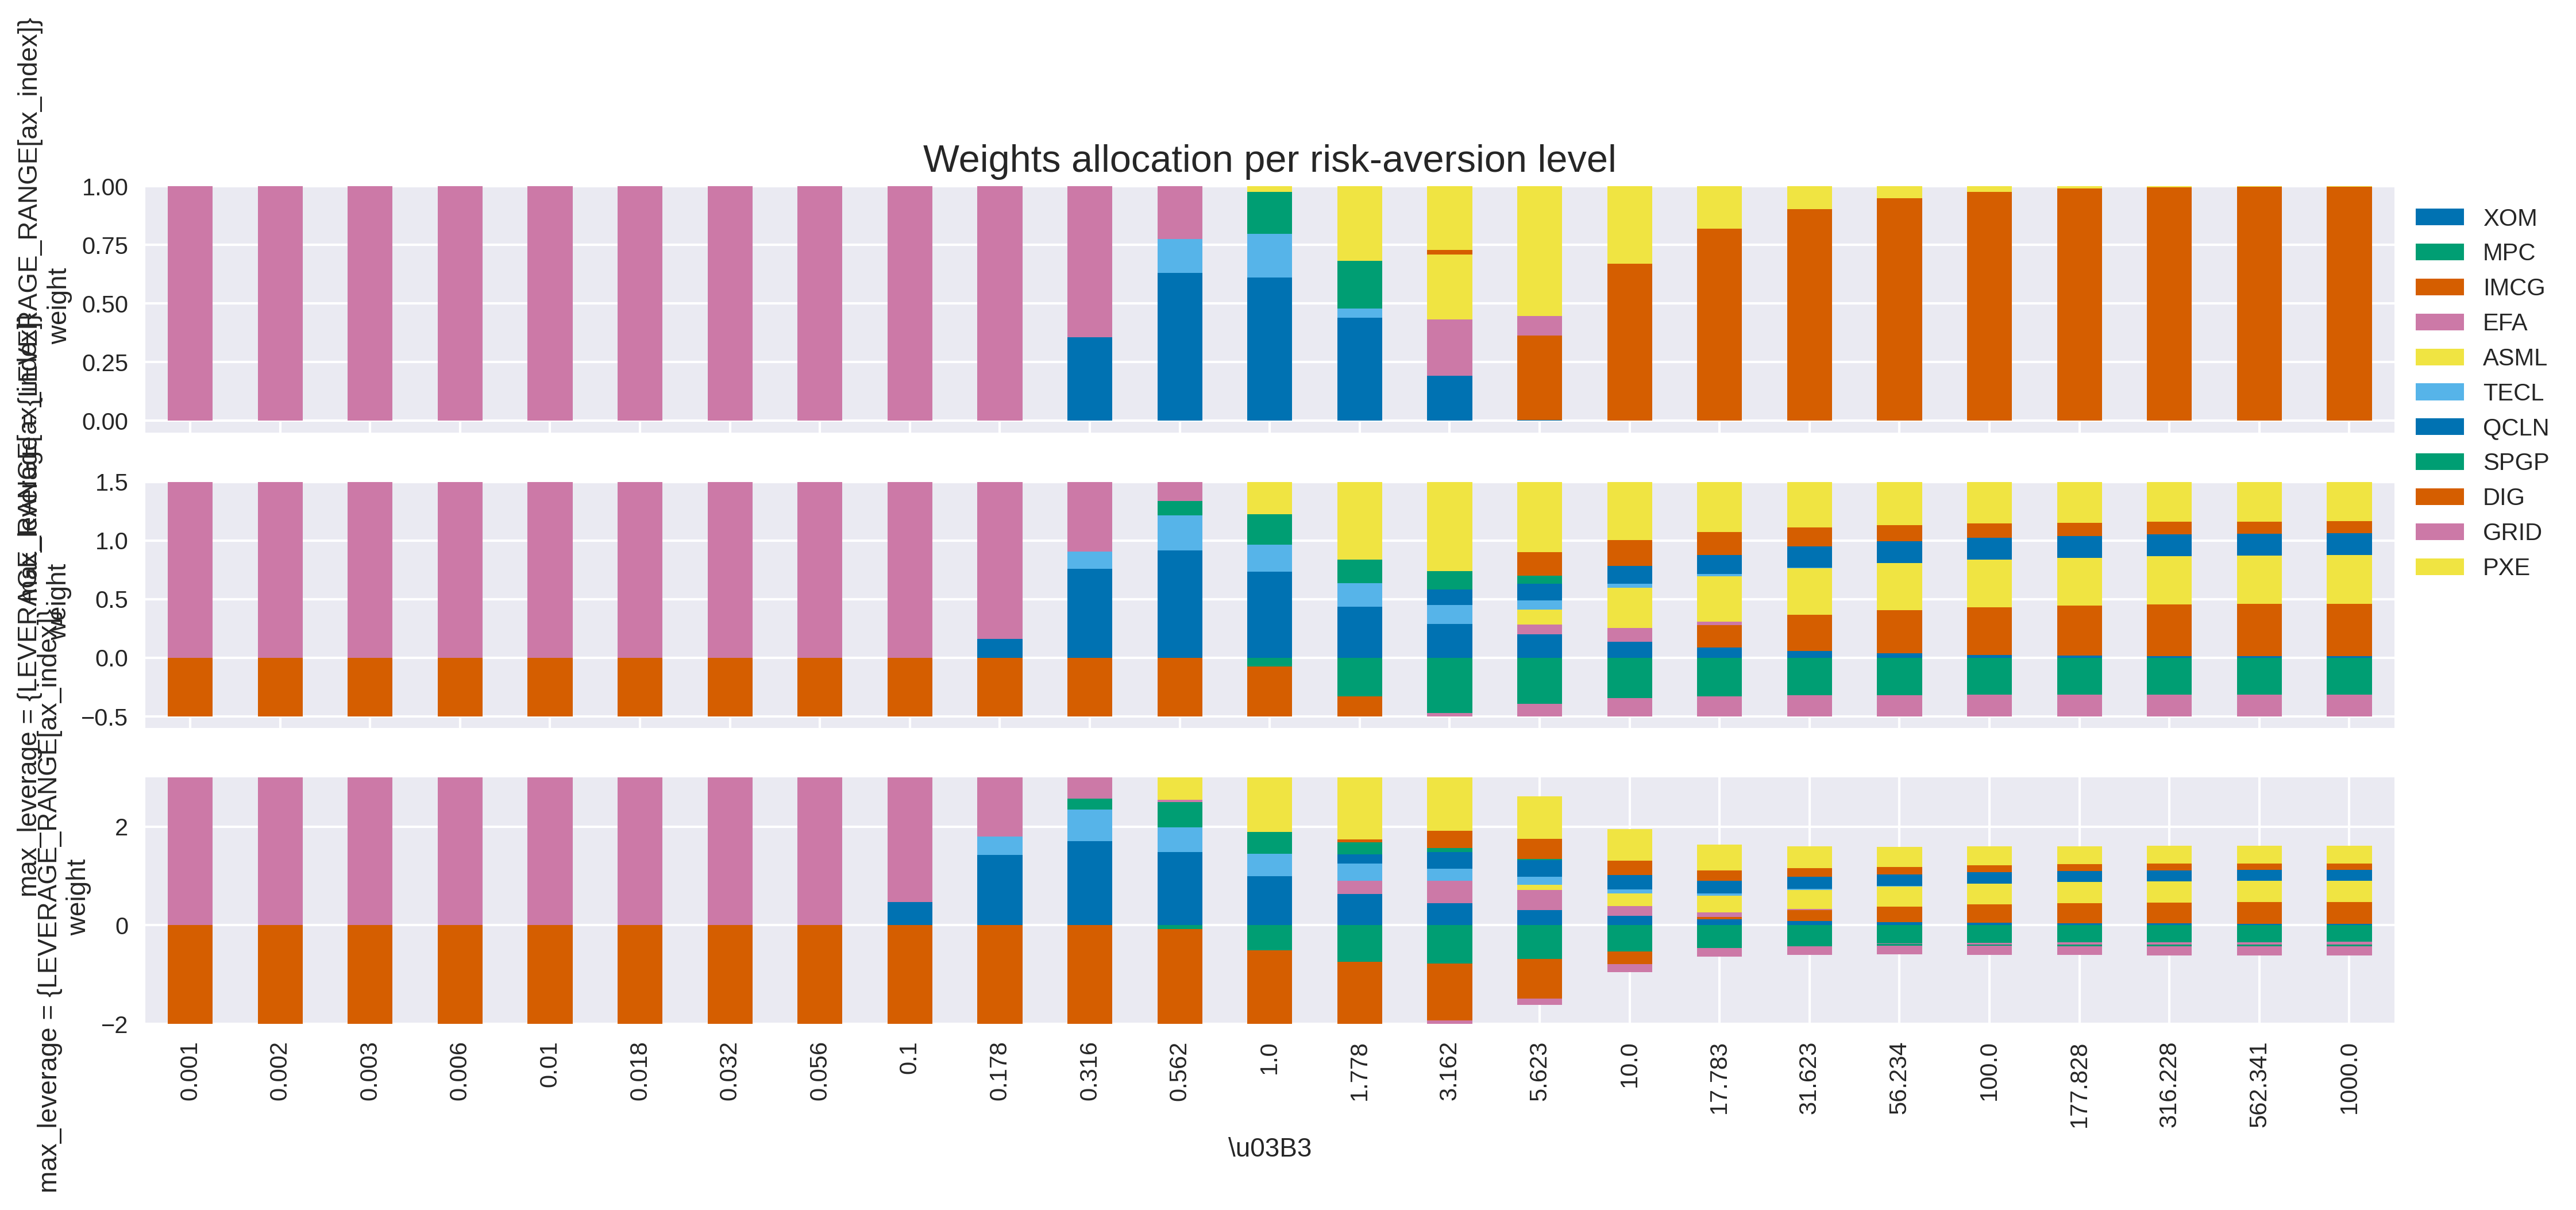

In [ ]:
fig, ax = plt.subplots(len_leverage, 1, sharex=True, figsize = (15,6))

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame(weights_ef[ax_index], 
                              columns=equities, 
                              index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar', 
                    stacked=True, 
                    ax=ax[ax_index], 
                    legend=None) 
    ax[ax_index].set(ylabel=('max_leverage = {LEVERAGE_RANGE[ax_index]}''\n weight'))

    
ax[len_leverage - 1].set(xlabel=r'\u03B3')
ax[0].legend(bbox_to_anchor=(1,1)) 
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)

plt.tight_layout()
plt.show()
     

In [ ]:
import numpy as np
ticker = "XOM"
start_date = datetime(2018,1,1)
end_date = datetime(2020,12,31)
class DataBase():
  def __init__(self, ticker, days):
    self.ticker = ticker
    data = yf.download(ticker, start = start_date, end =end_date )
    self.df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)
    self.df[self.df.index.dayofweek < 5]
    self.df= self.df[-days:]

  def quote(self):
    return self.df

db = DataBase(ticker, 1000)
df = db.quote()

df = df.loc[:, ['Adj Close']]
df = df.rename(columns={'Adj Close':'adj_close'})

df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
print(df)

[*********************100%***********************]  1 of 1 completed
            adj_close  simple_rtn   log_rtn
Date                                       
2018-01-02  64.879852         NaN       NaN
2018-01-03  66.154076    0.019640  0.019449
2018-01-04  66.245651    0.001384  0.001383
2018-01-05  66.192238   -0.000806 -0.000807
2018-01-08  66.489807    0.004496  0.004485
...               ...         ...       ...
2020-12-23  37.559826    0.012852  0.012770
2020-12-24  37.406956   -0.004070 -0.004078
2020-12-28  37.532845    0.003365  0.003360
2020-12-29  37.110218   -0.011260 -0.011324
2020-12-30  37.406956    0.007996  0.007964

[755 rows x 3 columns]


In [ ]:
df = df[['log_rtn']].dropna()
# function for calculating the realized volatility:
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

# monthly realized volatility
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv
     


log_rtn
Date                
2018-01-31  0.037856
2018-02-28  0.097259
2018-03-31  0.057055
2018-04-30  0.069874
2018-05-31  0.064163
2018-06-30  0.049712
2018-07-31  0.044484
2018-08-31  0.041701
2018-09-30  0.039667
2018-10-31  0.064814
2018-11-30  0.065165
2018-12-31  0.091381
2019-01-31  0.055224
2019-02-28  0.052672
2019-03-31  0.039946
2019-04-30  0.048224
2019-05-31  0.049947
2019-06-30  0.050327
2019-07-31  0.033372
2019-08-31  0.079155
2019-09-30  0.037461
2019-10-31  0.060431
2019-11-30  0.068947
2019-12-31  0.039619
2020-01-31  0.062228
2020-02-29  0.113850
2020-03-31  0.310907
2020-04-30  0.182105
2020-05-31  0.149272
2020-06-30  0.168018
2020-07-31  0.110725
2020-08-31  0.078671
2020-09-30  0.083898
2020-10-31  0.114407
2020-11-30  0.188954
2020-12-31  0.091864

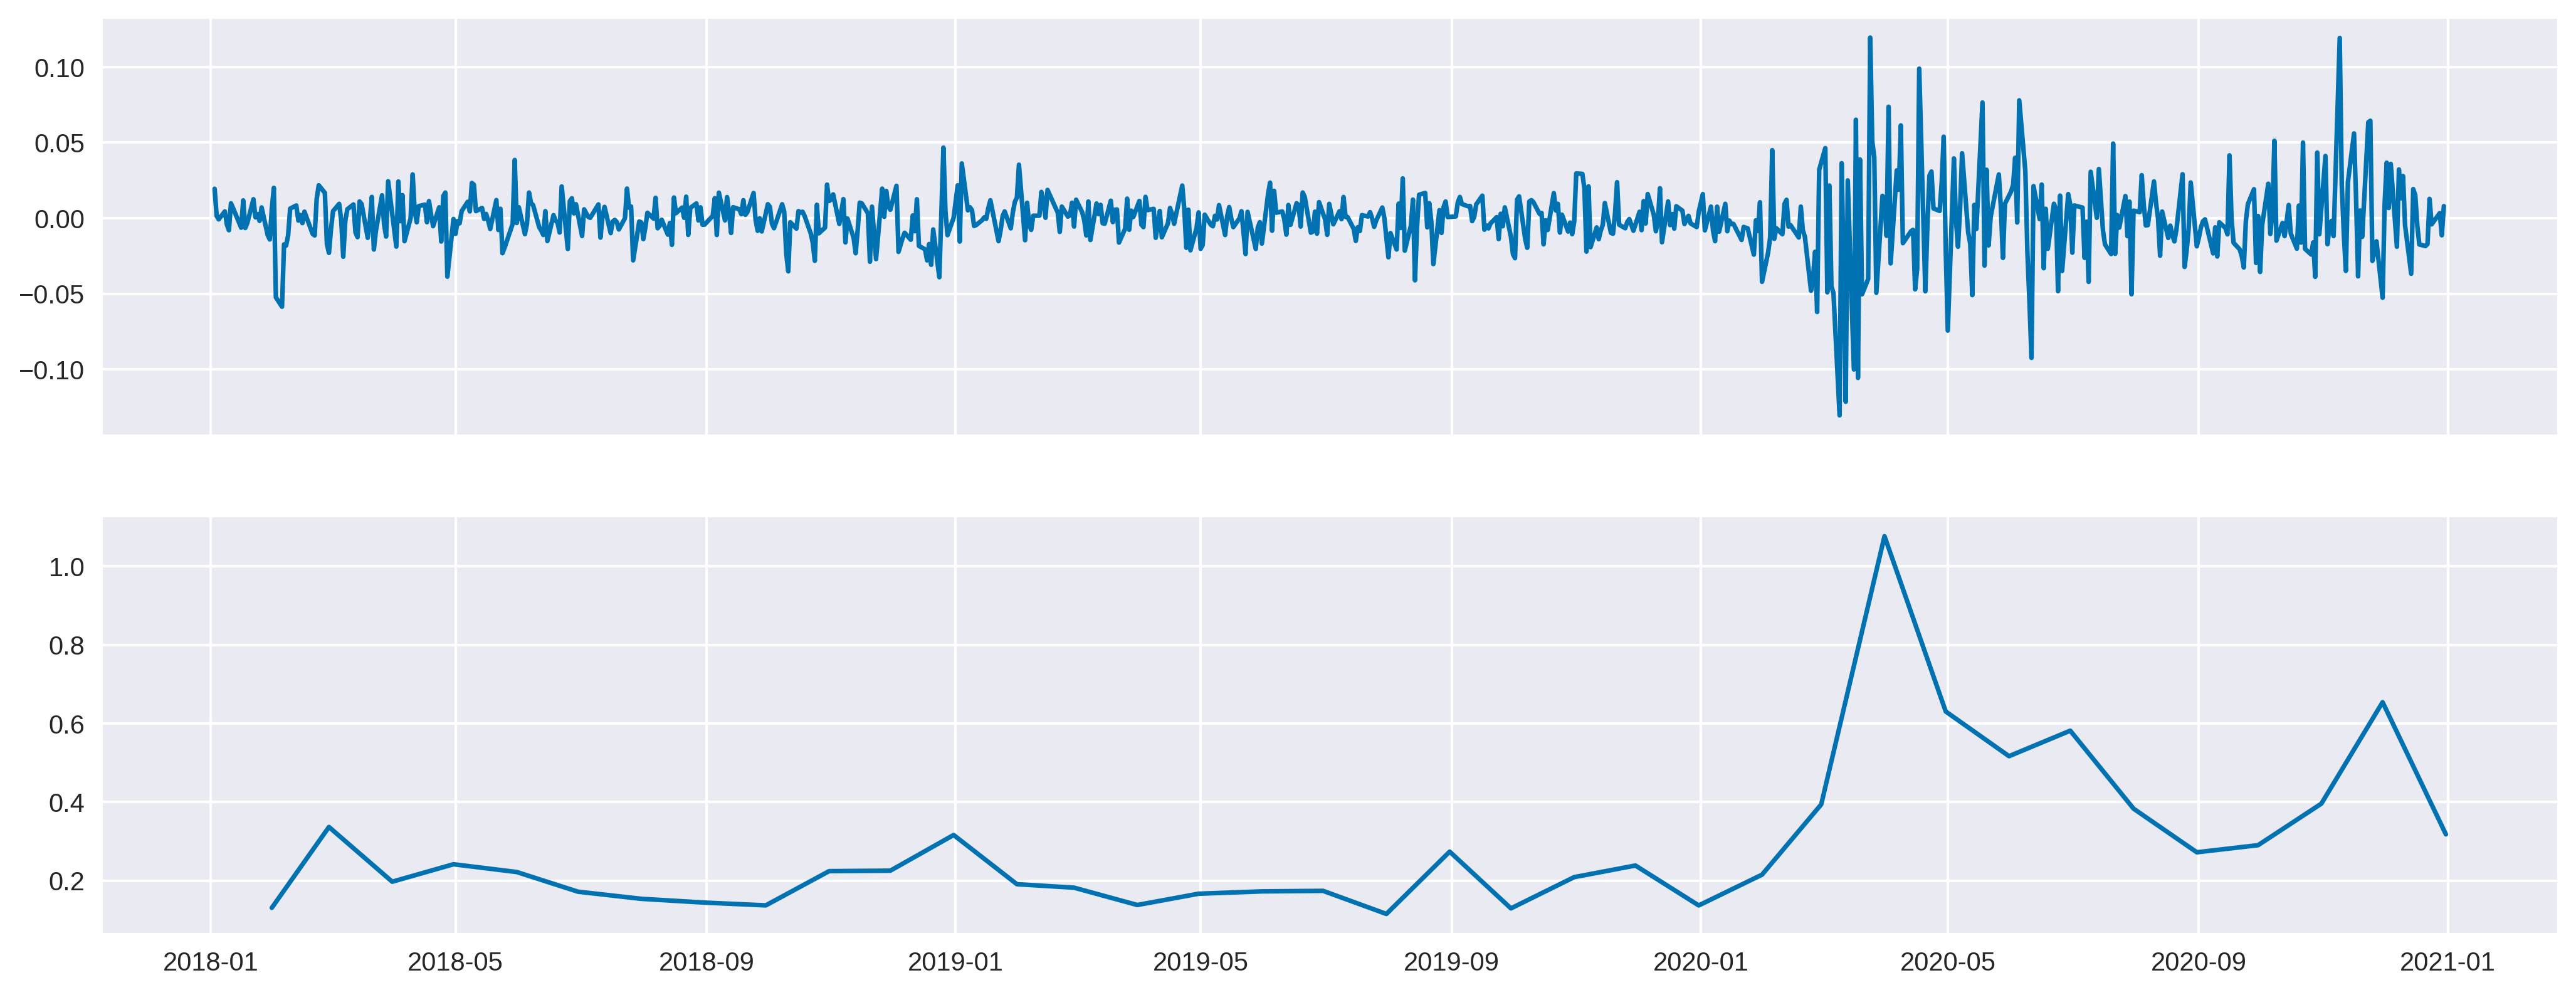

In [ ]:
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)
df_rv.rv = df_rv.rv * np.sqrt(12)
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (15,6))
ax[0].plot(df)
ax[1].plot(df_rv)

plt.grid(True)
plt.show()
    

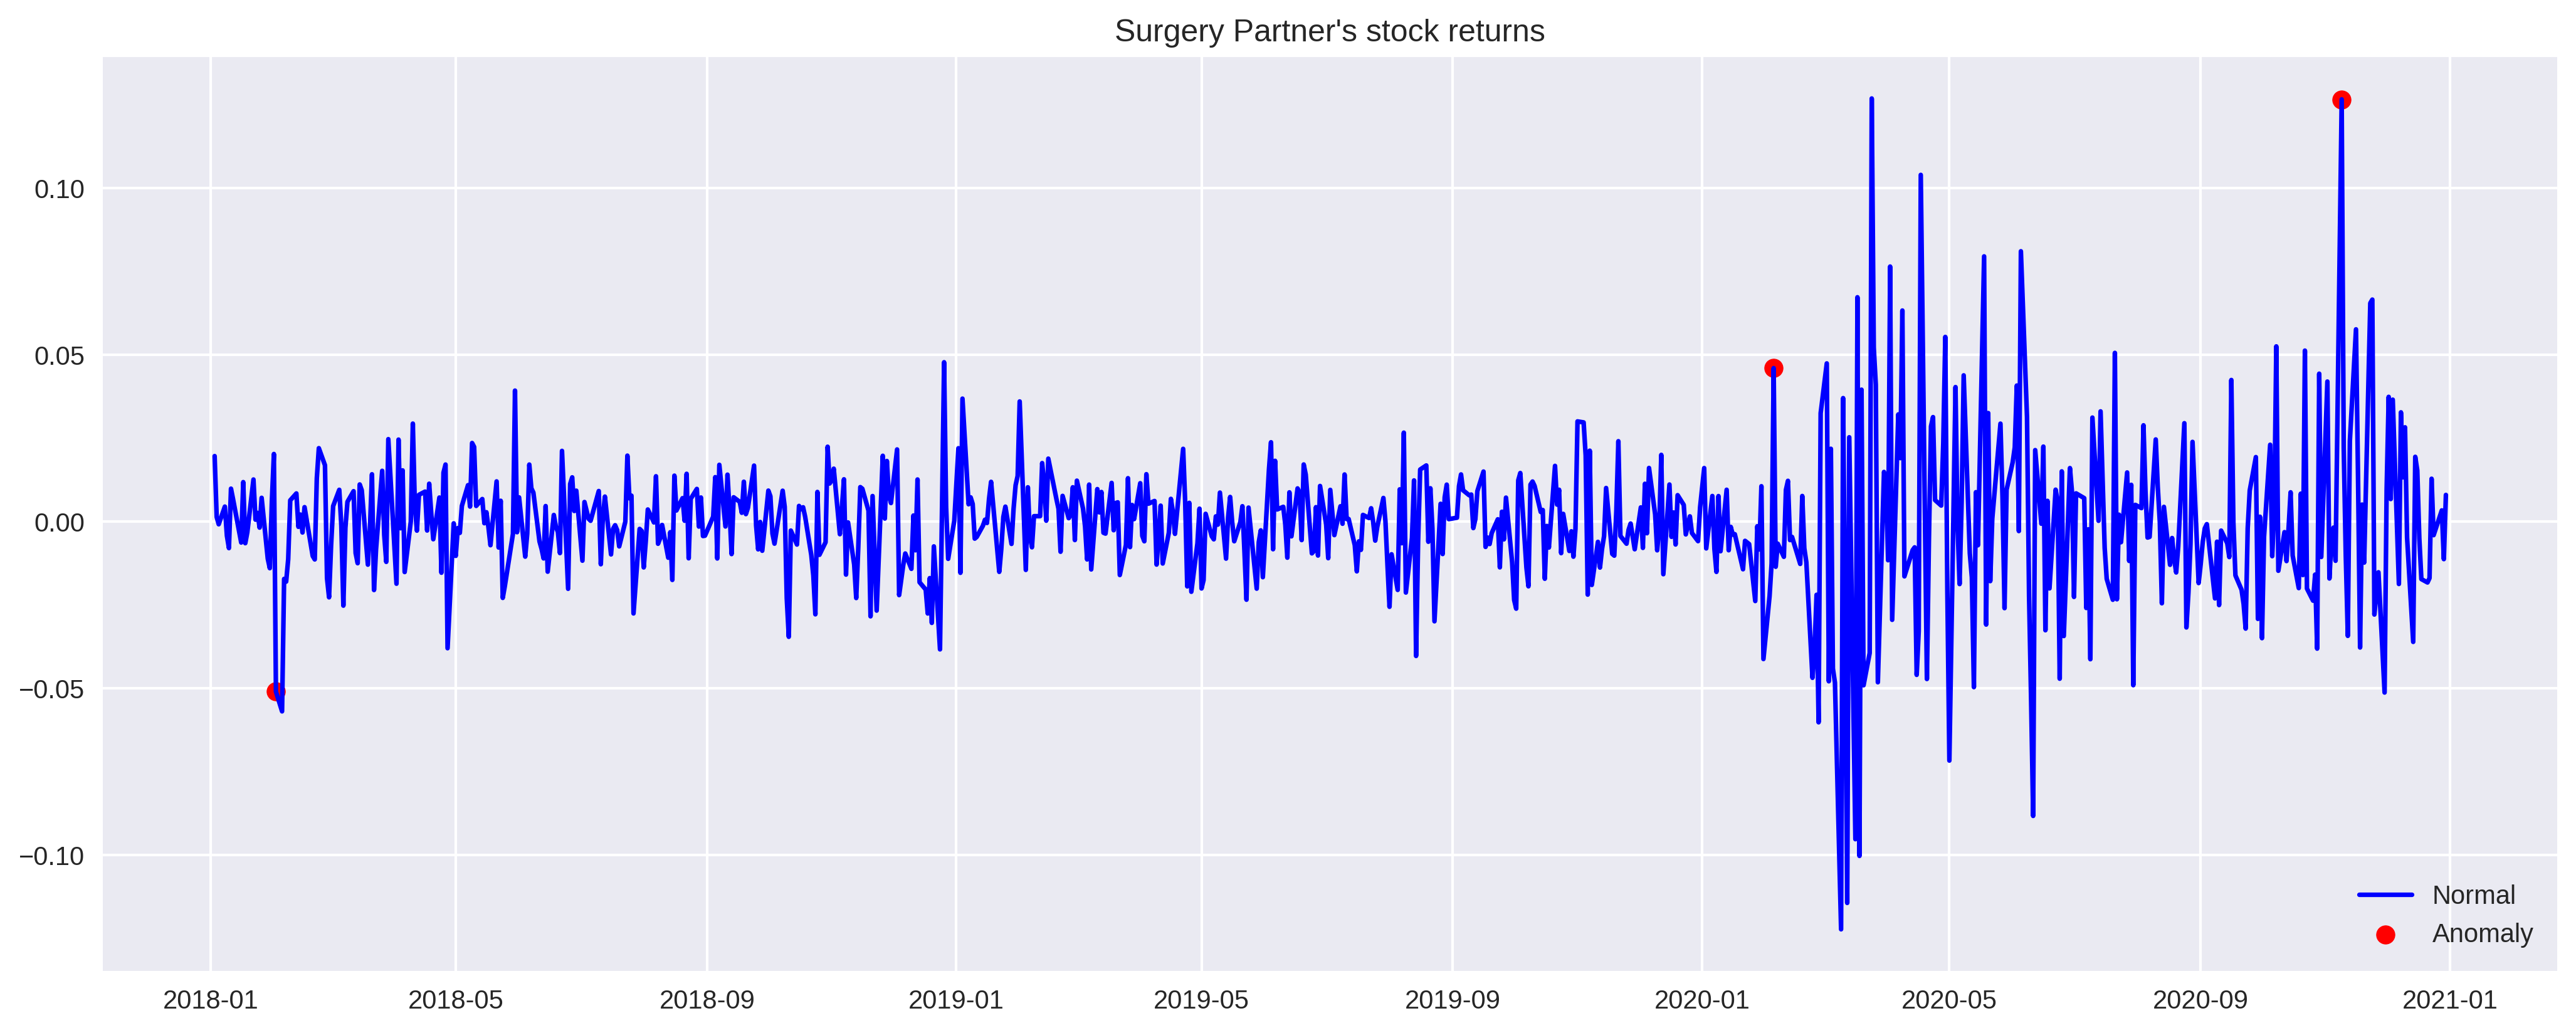

In [ ]:
df = db.quote()

df = df.loc[:, ['Adj Close']]
df = df.rename(columns={'Adj Close':'adj_close'})

df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
# print(df)

# Calculate the rolling mean and standard deviation:
df_rolling = df[['simple_rtn']].rolling(window=21) \
                               .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

# Join the rolling metrics to the original data:
df_outliers = df.join(df_rolling)

# Define a function for detecting outliers:
def indentify_outliers(row, n_sigmas=3):
    '''
    Function for identifying the outliers using the 3 sigma rule. 
    The row must contain the following columns/indices: simple_rtn, mean, std.
    
    Parameters
    ----------
    row : pd.Series
        A row of a pd.DataFrame, over which the function can be applied.
    n_sigmas : int
        The number of standard deviations above/below the mean - used for detecting outliers
        
    Returns
    -------
    0/1 : int
        An integer with 1 indicating an outlier and 0 otherwise.
    '''
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    
    if (x > mu + n_sigmas * sigma) | (x < mu - n_sigmas * sigma):
        return 1
    else:
        return 0

# Identify the outliers and extract their values for later use:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers, 
                                           axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]

# plot
fig, ax = plt.subplots(figsize = (15,6))

ax.plot(df_outliers.index, df_outliers.simple_rtn, 
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
           color='red', label='Anomaly')
ax.set_title("Surgery Partner's stock returns")
ax.legend(loc='lower right')

plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10000.00
2020-03-03, BUY CREATED --- Size: 210, Cash: 10000.00, Open: 47.529998779296875, Close: 45.16999816894531
2020-03-03, BUY EXECUTED --- Price: 47.53, Cost: 9981.30, Commission: 9.98
2020-05-04, SELL CREATED --- Size: 210
2020-05-04, SELL EXECUTED --- Price: 28.54, Cost: 9981.30,Commission: 5.99
2020-05-04, OPERATION RESULT --- Gross: -3987.90, Net: -4003.87
2020-07-13, BUY CREATED --- Size: 165, Cash: 5996.13, Open: 36.31999969482422, Close: 35.310001373291016
2020-07-13, Order Failed
2020-09-14, BUY CREATED --- Size: 190, Cash: 5996.13, Open: 31.489999771118164, Close: 32.02000045776367
2020-09-14, BUY EXECUTED --- Price: 31.49, Cost: 5983.10, Commission: 5.98
2020-11-05, SELL CREATED --- Size: 190
2020-11-05, SELL EXECUTED --- Price: 31.65, Cost: 5983.10,Commission: 6.01
2020-11-05, OPERATION RESULT --- Gross: 30.40, Net: 18.40
Final Portfolio Value: 6014.53


<IPython.core.display.Javascript object>

OrderedDict([('rtot', -0.5084070309548481), ('ravg', -0.002017488218074794), ('rnorm', -0.3985470880203248), ('rnorm100', -39.85470880203248)])


report_date  return
0    2020-01-02     0.0
1    2020-01-03     0.0
2    2020-01-06     0.0
3    2020-01-07     0.0
4    2020-01-08     0.0
..          ...     ...
247  2020-12-23     0.0
248  2020-12-24     0.0
249  2020-12-28     0.0
250  2020-12-29     0.0
251  2020-12-30     0.0

[252 rows x 2 columns]

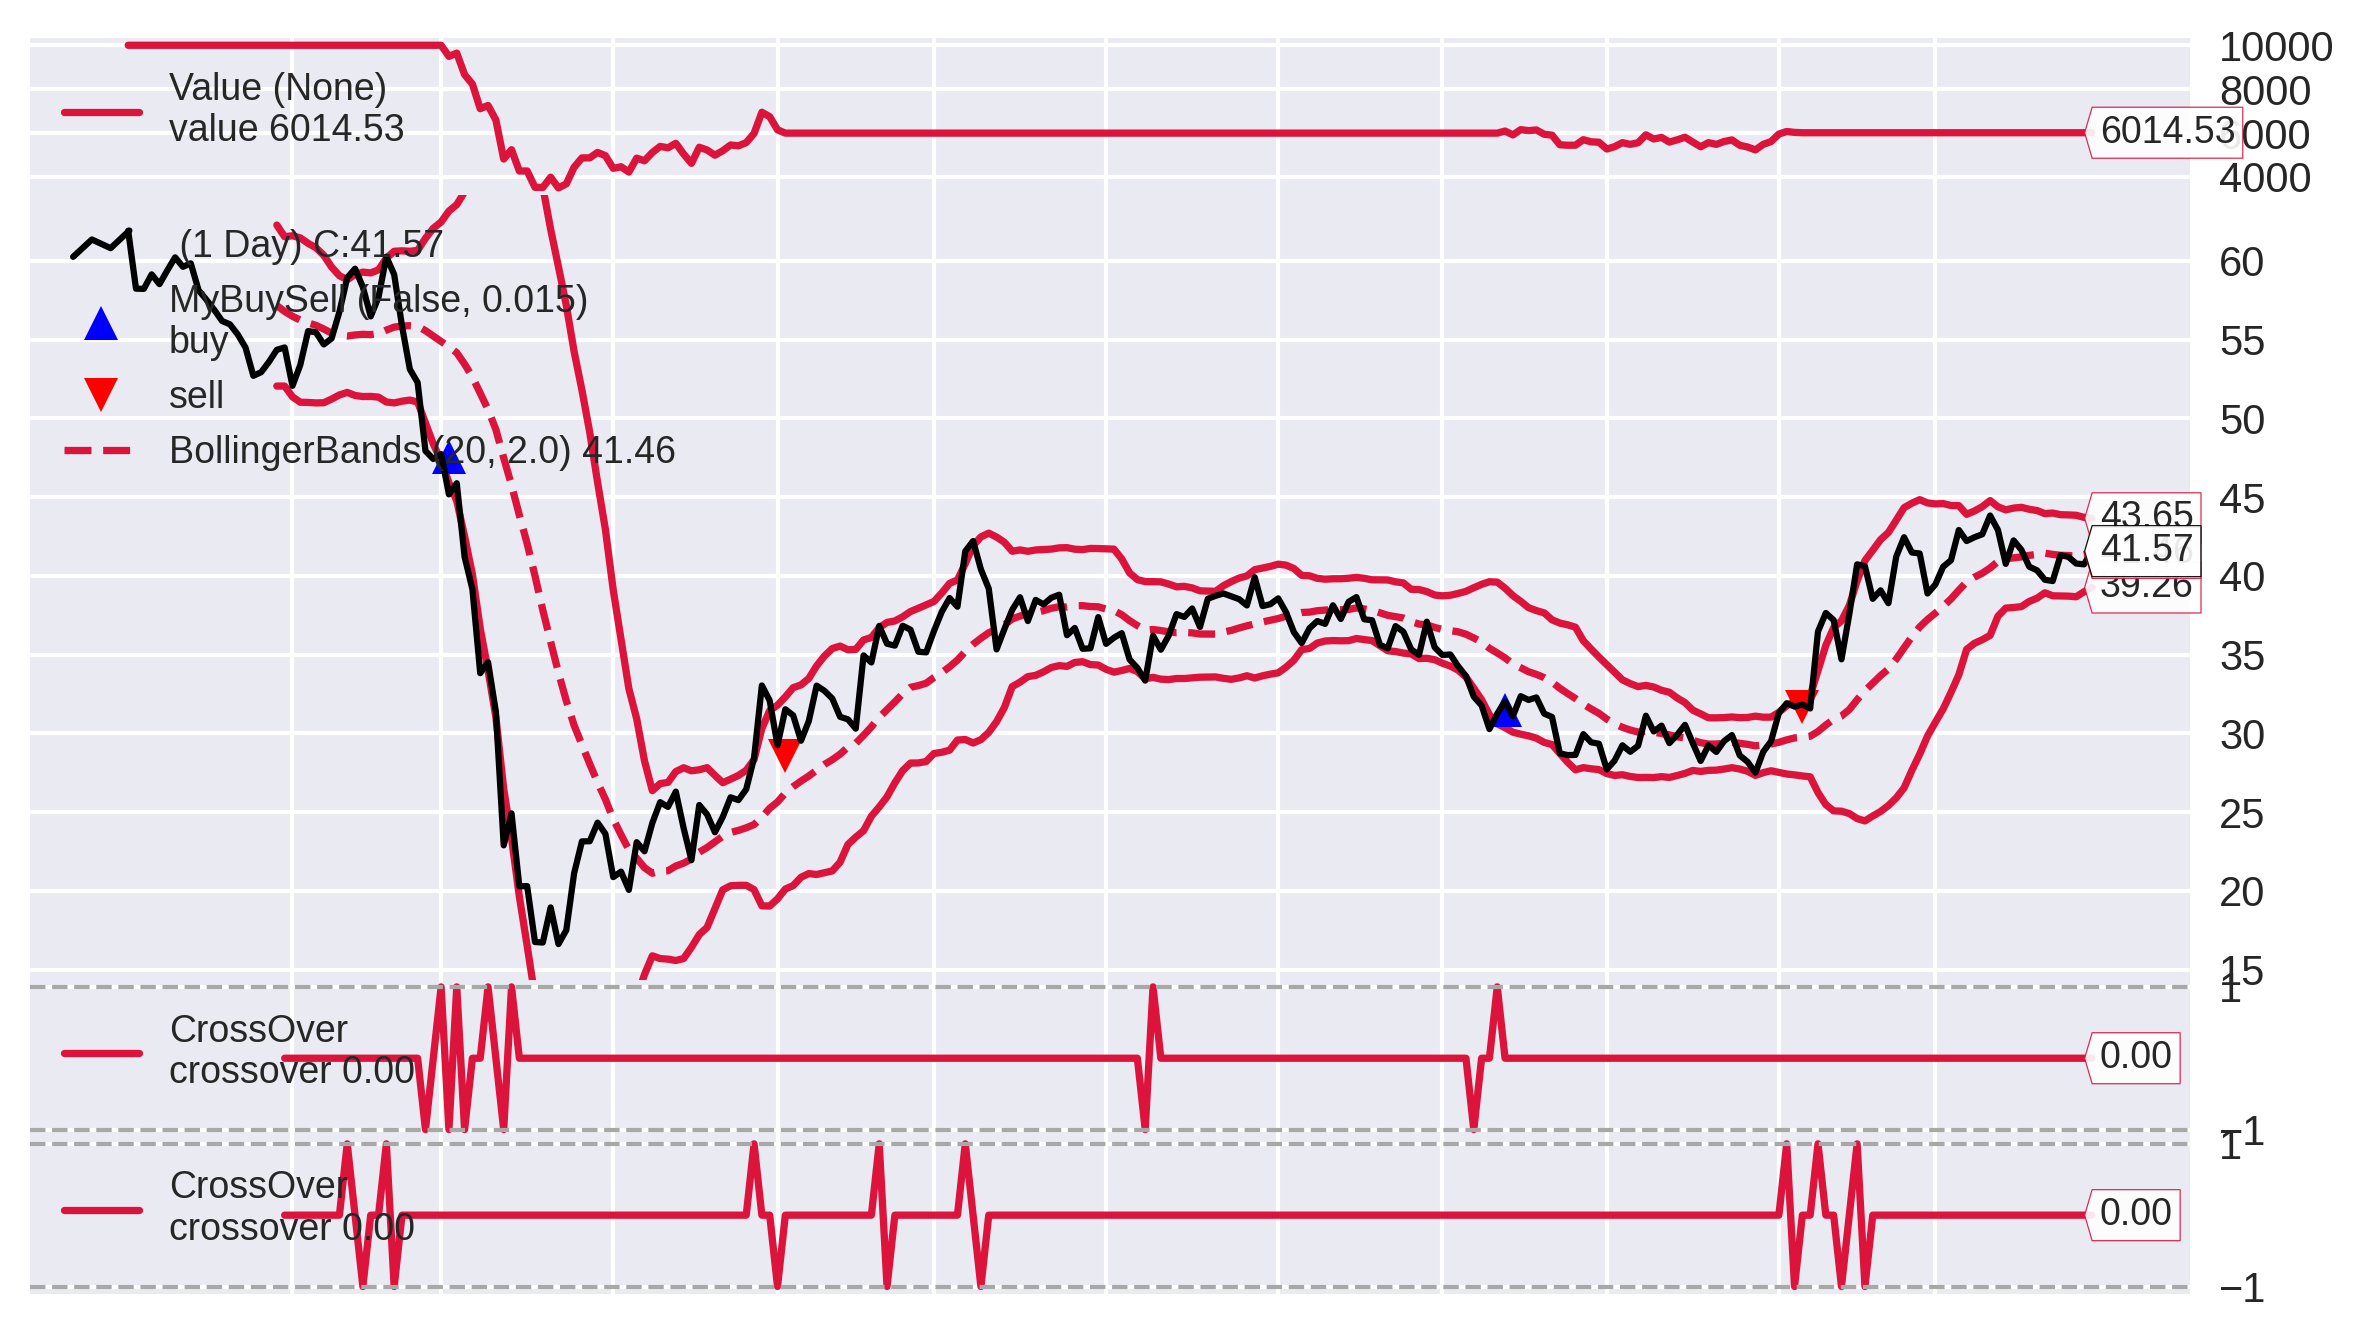

In [ ]:

class MyBuySell(bt.observers.BuySell):
    plotlines = dict(
        buy=dict(marker='^', markersize=8.0, color='blue', fillstyle='full'),
        sell=dict(marker='v', markersize=8.0, color='red', fillstyle='full')
    )


# create a Stratey
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 2.0),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0], period=self.p.period, devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.top)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(
                    f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
   # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.sell_signal < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)


class TradeSizer(bt.Sizer):
  params = (('stake', 1),)    
  def _getsizing(self, comminfo, cash, data, isbuy):        
    if isbuy: return self.p.stake        
    
    position = self.broker.getposition(data)        
    if not position.size: return 0        
    else: return position.size   
     
    return self.p.stake 

ticker = "MPC"
start_date = datetime(2020,1,1)
end_date = datetime(2020,12,31)
class DataBase():
  def __init__(self, ticker, days):
    self.ticker = ticker
    data = yf.download(ticker, start = start_date, end =end_date )
    self.df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)
    self.df[self.df.index.dayofweek < 5]
    self.df= self.df[-days:]

  def quote(self):
    return self.df

db = DataBase(ticker, 1000)
df = db.quote()
data = bt.feeds.PandasData(dataname=df)

# Create a cerebro entity
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

# set up the backtest
cerebro.addstrategy(BBand_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(MyBuySell)
cerebro.addsizer(TradeSizer)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')


print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.plot(iplot=True, volume=False)

# returns analyzer
print(backtest_result[0].analyzers.returns.get_analysis())

# returns over time analyzer
#%%
# plt.style.use('seaborn') #set style to `seaborn`
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
pd.DataFrame(list(returns_dict.items()), columns = ['report_date', 'return'])

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10000.00
Final Portfolio Value: 9981.02


<IPython.core.display.Javascript object>

OrderedDict([('rtot', -0.0019001144485072696), ('ravg', -7.540136700425673e-06), ('rnorm', -0.0018983103738788865), ('rnorm100', -0.18983103738788865)])


report_date  return
0    2020-01-02     0.0
1    2020-01-03     0.0
2    2020-01-06     0.0
3    2020-01-07     0.0
4    2020-01-08     0.0
..          ...     ...
247  2020-12-23     0.0
248  2020-12-24     0.0
249  2020-12-28     0.0
250  2020-12-29     0.0
251  2020-12-30     0.0

[252 rows x 2 columns]

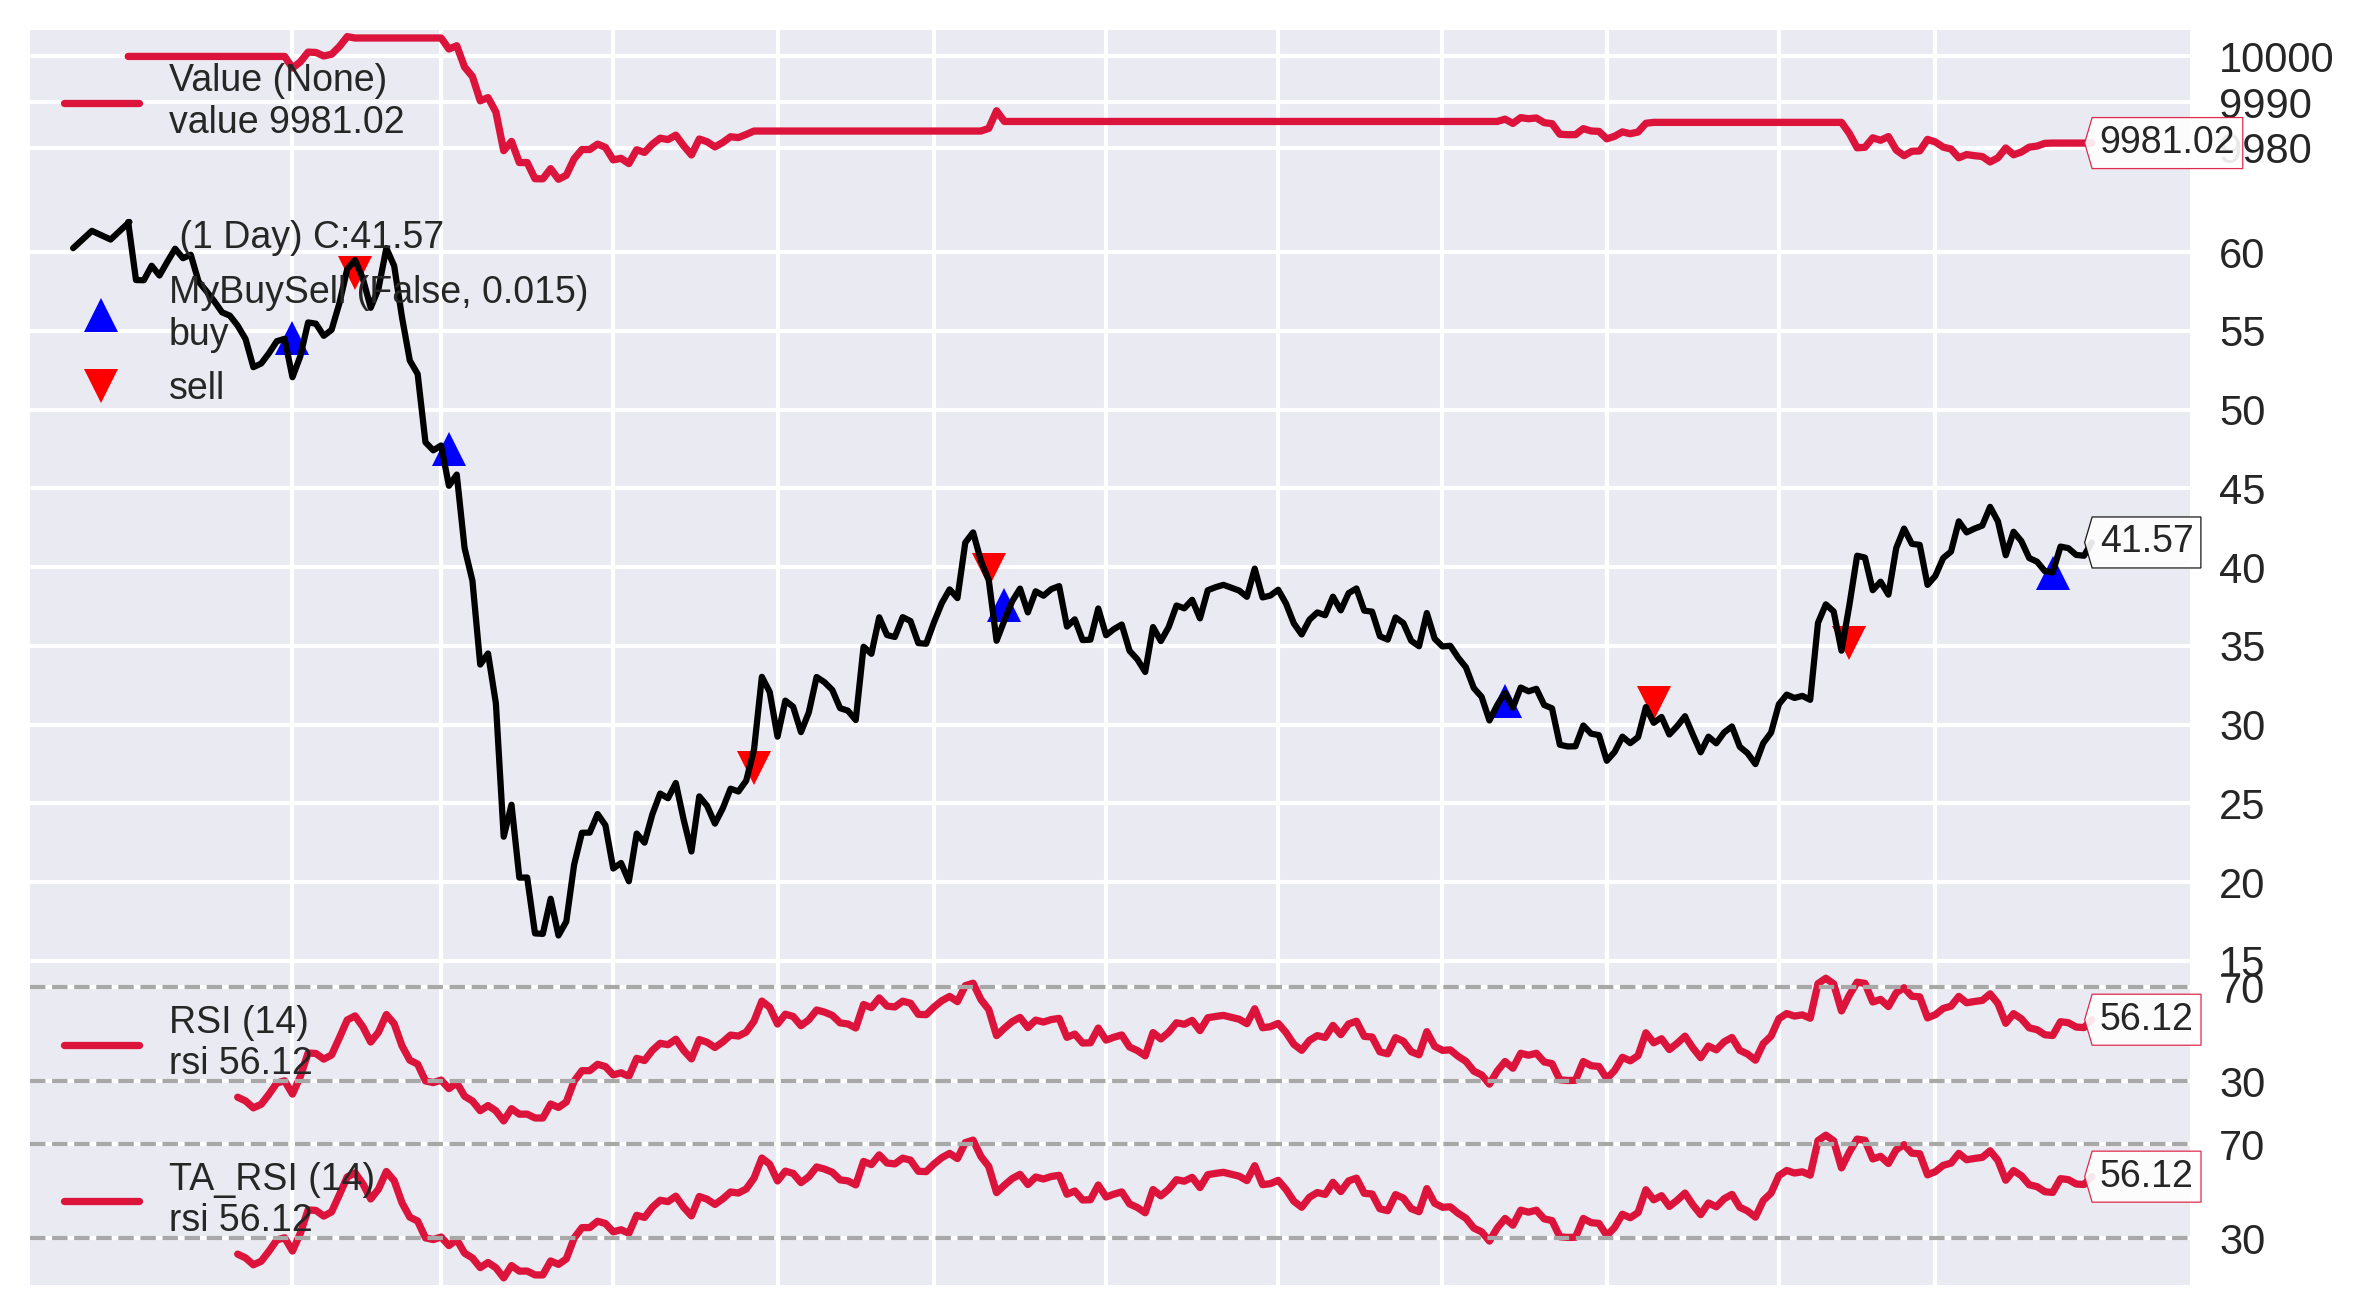

In [ ]:
class MyBuySell(bt.observers.BuySell):
    plotlines = dict(
        buy=dict(marker='^', markersize=8.0, color='blue', fillstyle='full'),
        sell=dict(marker='v', markersize=8.0, color='red', fillstyle='full')
    )

# create a Stratey
class RsiSignalStrategy(bt.SignalStrategy):
    params = dict(rsi_periods=14, rsi_upper=70, rsi_lower=30, rsi_mid=50)

    def __init__(self):

        # add RSI indicator
        rsi = bt.indicators.RSI(period=self.p.rsi_periods,
                                upperband=self.p.rsi_upper,
                                lowerband=self.p.rsi_lower)

        # add RSI from TA-lib just for reference
        bt.ind.RSI(self.data, plotname='TA_RSI')

        # long condition (with exit)
        rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower, plot=False)
        self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
        self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi > self.p.rsi_mid))

        # short condition (with exit)
        rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper, plot=False)
        self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
        self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid)


ticker = "MPC"
start_date = datetime(2020,1,1)
end_date = datetime(2020,12,31)
class DataBase():
  def __init__(self, ticker, days):
    self.ticker = ticker
    data = yf.download(ticker, start = start_date, end =end_date )
    self.df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)
    self.df[self.df.index.dayofweek < 5]
    self.df= self.df[-days:]

  def quote(self):
    return self.df
db = DataBase(ticker, 1000)
df = db.quote()
data = bt.feeds.PandasData(dataname=df)



# create a Cerebro entity
cerebro = bt.Cerebro(stdstats = False)

# # set up the backtest
cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')


print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.plot(iplot=True, volume=False)

# returns analyzer
print(backtest_result[0].analyzers.returns.get_analysis())

# returns over time analyzer
#%%
# plt.style.use('seaborn') #set style to `seaborn`
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
pd.DataFrame(list(returns_dict.items()), columns = ['report_date', 'return'])

In [ ]:
class MyBuySell(bt.observers.BuySell):
    plotlines = dict(
        buy=dict(marker='^', markersize=8.0, color='blue', fillstyle='full'),
        sell=dict(marker='v', markersize=8.0, color='red', fillstyle='full')
    )

class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
# set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()
ticker = "NTRA"
start_date = dt.datetime(2020,1,1)
end_date = dt.datetime(2020,12,31)
class DataBase():
  def __init__(self, ticker, days):
    self.ticker = ticker
    data = yf.download(ticker, start = start_date, end =end_date )
    self.df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)
    self.df[self.df.index.dayofweek < 5]
    self.df= self.df[-days:]

  def quote(self):
    return self.df

db = DataBase(ticker, 1000)
df = db.quote()
data = bt.feeds.PandasData(dataname=df)

cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')
     

In [ ]:
!pip install chart_studio
import chart_studio.plotly as py
from chart_studio.plotly import iplot
import ipywidgets as wd
from ipywidgets import interact, interact_manual
import cufflinks as cf
import pandas as pd 
import yfinance as yf
# from plotly import __version__ 
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 4.5 MB/s eta 0:00:00


In [ ]:
stocks = equities
indicators = ['Bollinger Bands', 'MACD', 'RSI']

# function for creating the interactive plot:
def ta_dashboard(stocks, indicator, start_date, end_date, 
                 bb_k, bb_n, macd_fast, macd_slow, macd_signal,
                 rsi_periods, rsi_upper, rsi_lower):
    
    df = yf.download(stocks, 
                     start=start_date, 
                     end=end_date,
                     progress=False,
                     auto_adjust=True)

    qf = cf.QuantFig(df, title=f'TA Dashboard - {stocks}', 
                     legend='right', name=f'{stocks}')
            
    if 'Bollinger Bands' in indicator: 
        qf.add_bollinger_bands(periods=bb_n, 
                               boll_std=bb_k)
    if 'MACD' in indicator: 
        qf.add_macd(fast_period=macd_fast, 
                    slow_period=macd_slow, 
                    signal_period=macd_signal)
    if 'RSI' in indicator: 
        qf.add_rsi(periods=rsi_periods, 
                   rsi_upper=rsi_upper, 
                   rsi_lower=rsi_lower, 
                   showbands=True)

    return qf.iplot()


# Define the selectors:
stocks_selector = wd.Dropdown(
    options=stocks, 
    value=stocks[0], 
    description='Asset'
)

In [ ]:
indicator_selector = wd.SelectMultiple(
    description='Indicator',
    options=indicators, 
    value=[indicators[0]]
)

start_date_selector = wd.DatePicker(
    description='Start Date', 
    value=pd.to_datetime('2020-01-01'), 
    continuous_update=False
)

end_date_selector = wd.DatePicker(
    description='End Date', 
    value=pd.to_datetime('2020-12-31'), 
    continuous_update=False
)

# Define a label and group the selectors inside a container:
main_selector_label = wd.Label('Main parameters', 
                               layout=wd.Layout(height='45px'))

main_selector_box = wd.VBox(children=[main_selector_label,
                                      stocks_selector,
                                      indicator_selector,
                                      start_date_selector,
                                      end_date_selector])

# Define the secondary selectors for Bollinger Bands:
bb_label = wd.Label('Bollinger Bands')

n_param = wd.IntSlider(value=20, min=1, max=40, step=1, 
                       description='N:', continuous_update=False)

k_param = wd.FloatSlider(value=2, min=0.5, max=4, step=0.5, 
                         description='k:', continuous_update=False)

bollinger_box = wd.VBox(children=[bb_label, n_param, k_param])


In [ ]:
# Define the secondary selectors for Bollinger Bands:
bb_label = wd.Label('Bollinger Bands')

n_param = wd.IntSlider(value=20, min=1, max=40, step=1, 
                       description='N:', continuous_update=False)

k_param = wd.FloatSlider(value=2, min=0.5, max=4, step=0.5, 
                         description='k:', continuous_update=False)

bollinger_box = wd.VBox(children=[bb_label, n_param, k_param])

# Define the secondary selectors for MACD:
macd_label = wd.Label('MACD')

macd_fast = wd.IntSlider(value=12, min=2, max=50, step=1, 
                         description='Fast avg:', 
                         continuous_update=False)

macd_slow = wd.IntSlider(value=26, min=2, max=50, step=1, 
                         description='Slow avg:', 
                         continuous_update=False)

macd_signal = wd.IntSlider(value=9, min=2, max=50, step=1, 
                           description='MACD signal:', 
                           continuous_update=False)

macd_box = wd.VBox(children=[macd_label, macd_fast, 
                             macd_slow, macd_signal])

# Define the secondary selectors for RSI:
rsi_label = wd.Label('RSI')

rsi_periods = wd.IntSlider(value=14, min=2, max=50, step=1, 
                           description='RSI periods:', 
                           continuous_update=False)

rsi_upper = wd.IntSlider(value=70, min=1, max=100, step=1, 
                         description='Upper Thr:', 
                         continuous_update=False)

rsi_lower = wd.IntSlider(value=30, min=1, max=100, step=1, 
                         description='Lower Thr:', 
                         continuous_update=False)

rsi_box = wd.VBox(children=[rsi_label, rsi_periods, 
                            rsi_upper, rsi_lower])

# Create the labels and group the selectors into containers:
sec_selector_label = wd.Label('Secondary parameters', 
                              layout=wd.Layout(height='45px'))
blank_label = wd.Label('', layout=wd.Layout(height='45px'))

sec_box_1 = wd.VBox([sec_selector_label, bollinger_box, macd_box])
sec_box_2 = wd.VBox([blank_label, rsi_box])

secondary_selector_box = wd.HBox([sec_box_1, sec_box_2])

# Group the boxes and prepare the interactive output:
controls_dict = {'stocks':stocks_selector, 
                 'indicator':indicator_selector, 
                 'start_date':start_date_selector, 
                 'end_date':end_date_selector, 
                 'bb_k':k_param, 
                 'bb_n':n_param,
                 'macd_fast': macd_fast, 
                 'macd_slow': macd_slow, 
                 'macd_signal': macd_signal,
                 'rsi_periods': rsi_periods, 
                 'rsi_upper': rsi_upper,
                 'rsi_lower': rsi_lower}

ui = wd.HBox([main_selector_box, secondary_selector_box])
out = wd.interactive_output(ta_dashboard, controls_dict)

# Display the dashboard:
display(ui, out)

Output()